<a href="https://colab.research.google.com/github/yuukun123/Python/blob/master/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# Tùy chỉnh để hiển thị biểu đồ đẹp hơn
sns.set(style="whitegrid")

Mounted at /content/drive


In [ ]:
# Đường dẫn file
file_path = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/DelawarePainDatabase_SecondaryDatabase_FaceGenCharacterization.xlsx"
xls = pd.ExcelFile(file_path)

# **clean DelawarePainDatabase_SecondaryDatabase_FaceGenCharacterization.xlsx**

hàm lọc dữ liệu sheet ExpressionAverage


In [ ]:
# def clean_expression_sheet(df, required_cols=["Expression"]):
#     # Xóa cột không tên
#     df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

#     # Xóa dòng thiếu cột bắt buộc
#     df = df.dropna(subset=required_cols)

#     # Loại bỏ các biểu cảm không dùng
#     df = df[~df["Expression"].str.lower().str.contains("pms13")]
#     df = df[~df["Expression"].str.lower().str.contains("facegenpro_avgblackface")]

#     # Các cột cần ép kiểu và xử lý NaN
#     numeric_cols = ["ThreatRating", "ConfusionRating", "ThreatComp", "ConfusionComp"]
#     for col in numeric_cols:
#         if col in df.columns:
#             df[col] = df[col].replace([".", ""], np.nan)
#             df[col] = pd.to_numeric(df[col], errors="coerce")
#             df[col] = df[col].fillna(df[col].mean())

#     # Loại bỏ các dòng liên quan face gen pro
#     df = df[~df["Norming Survey"].str.lower().str.contains("facegenpro")]

#     df = df.infer_objects(copy=False)

#     return df


In [ ]:
def clean_expression_sheet(df, required_cols=["Expression"]):
  # Xóa cột không tên
  df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

  # Xóa dòng thiếu cột bắt buộc
  df = df.dropna(subset=required_cols)

  # Loại bỏ các biểu cảm không dùng
  df = df[~df["Expression"].str.lower().str.contains("pms13")]
  df = df[~df["Expression"].str.lower().str.contains("facegenpro_avgblackface")]

  # ✅ Loại bỏ các dòng liên quan face gen pro TRƯỚC để không ảnh hưởng đến mean
  df = df[~df["Norming Survey"].str.lower().str.contains("facegenpro")]

  # Các cột cần ép kiểu và xử lý NaN
  numeric_cols = ["ThreatRating", "ConfusionRating", "ThreatComp", "ConfusionComp"]
  for col in numeric_cols:
      if col in df.columns:
          df[col] = df[col].replace([".", ""], np.nan)
          df[col] = pd.to_numeric(df[col], errors="coerce")
          df[col] = df[col].fillna(df[col].mean())

  df = df.loc[:, ~df.columns.str.contains("ConfusionRating")]
  df = df.loc[:, ~df.columns.str.contains("ConfusionComp")]

  df = df.infer_objects(copy=False)
  return df


ExpressionAverages

In [ ]:
df_expr = pd.read_excel(xls, sheet_name="ExpressionAverages")
# print(df_expr.dtypes)
df_expr = clean_expression_sheet(df_expr)

print(df_expr.to_string())

   Expression Norming Survey  PainRating  FearRating  AngerRating  DisgustRating  HappinessRating  SadnessRating  SurpriseRating  ThreatRating      FearComp     AngerComp   DisgustComp  HappinessComp   SadnessComp  SurpriseComp    ThreatComp
0         AJ2      FirstPass    5.052632    2.894737     2.078947       2.421053         1.210526       3.131579        2.131579      1.736842  2.033766e-06  9.570970e-08  3.064130e-07   1.954638e-12  1.372440e-04  6.551333e-07  3.610371e-09
3         AK5      FirstPass    4.650000    2.225000     2.725000       2.575000         1.275000       2.275000        1.725000      2.375000  7.102722e-09  4.114614e-05  2.849266e-06   6.427339e-13  3.038153e-08  1.352565e-10  1.223136e-07
6         EF5      FirstPass    5.837838    2.594595     4.378378       3.162162         1.324324       1.864865        2.378378      3.351351  1.203900e-09  3.054509e-03  2.977539e-07   2.203910e-15  3.098174e-13  5.076302e-11  6.699533e-06
9         KM4      FirstPass    

<ipython-input-18-63b2d55437d4>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace([".", ""], np.nan)


hàm lọc dữ liệu sheet slider_face_gen

In [ ]:
import numpy as np
import pandas as pd

def clean_slider_facegen_sheet(df):
    # Xóa các cột không tên
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

    # Loại bỏ cột 'PMS13' nếu có
    if "PMS13" in df.columns:
        df = df.drop(columns=["PMS13"])

    # Lưu lại danh sách Slider gốc
    slider_labels = df["Slider"].values

    # Xử lý các cột số
    numeric_cols = df.columns.drop("Slider")
    for col in numeric_cols:
        df[col] = df[col].replace([".", ""], np.nan)
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df[col] = df[col].fillna(df[col].mean())

    df = df.infer_objects(copy=False)

    # Bây giờ transpose
    df = df.set_index("Slider").transpose()

    # Sau khi transpose:
    # Reset index để 'Slider' thành 1 cột
    df.reset_index(inplace=True)

    # Đổi tên cột đầu tiên thành 'Slider'
    df = df.rename(columns={"index": "Slider"})

    # >>> THÊM BƯỚC TẠO ExpressionKey <<<
    df["ExpressionKey"] = df["Slider"].astype(str).str.strip().str.upper()

    return df


Slider_face_gen

In [ ]:
df_slider_mo = pd.read_excel(xls, sheet_name="Sliders_FaceGenModeller")
# print(df_slider_mo.dtypes)
df_slider_mo = clean_slider_facegen_sheet(df_slider_mo)
print(df_slider_mo.to_string())

Slider Slider    Anger   Disgust      Fear   Sad  SmileClosed  SmileOpen  Surprise  BlinkLeft  BlinkRIght  BrowDownLeft  BrowDownRight  BrowInLeft  BrownInRight  BrowUpLeft  BrowUpRight   EarsOut  EpicanthicFold  EyeSquintLeft  EyeSquintRight  LookDown  LookLeft  LookRight    LookUp       aah     B,M,P   big aah   ch,J,sh     D,S,T        ee        eh       F,V         i         K         N        oh     ooh,Q         R        th         W ExpressionKey
0         AK5  0.22000  0.480000  0.551818  0.83     0.551818   0.551818  0.551818   0.560000    0.570000      1.000000       1.000000    0.551818      0.551818    0.551818     0.551818  0.551818        0.630000       0.551818        0.551818  0.551818  0.551818   0.551818  0.551818  0.090000  0.551818  0.551818  0.500000  0.551818  0.551818  0.551818  0.551818  0.551818  0.551818  0.551818  0.190000  0.551818  0.551818  0.551818  0.551818           AK5
1         AJ2  0.43800  0.210000  1.000000  1.00     0.438000   0.800000  0.438000  

<ipython-input-70-b690d0cf75c9>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace([".", ""], np.nan)


hàm lọc first_pass_norming

In [ ]:
# def clean_first_pass_norming(df):
#     import pandas as pd


#     # 1. Loại cột chứa 'pms13'
#     df = df.loc[:, ~df.columns.str.contains("pms13", case=False)]

#     # 2. Loại bỏ các cột nhân khẩu học không cần thiết
#     drop_cols = ['Race', 'SexualOrient', 'Political']
#     df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

#     # 3. Tìm các cột đánh giá cảm xúc
#     rating_cols = [c for c in df.columns if "emotion" in c.lower()]

#     # 4. Tính tỷ lệ thiếu
#     miss_ratios = df[rating_cols].isna().mean()

#     # 5. Giữ lại các cột có missing <= 0.4
#     keep_cols = miss_ratios[miss_ratios <= 0.4].index.tolist()
#     df = df[keep_cols + [col for col in df.columns if col not in rating_cols]]

#     # 6. Phân loại cột theo mức độ thiếu
#     small_missing = miss_ratios[miss_ratios < 0.05].index.tolist()
#     large_missing = miss_ratios[(miss_ratios >= 0.05) & (miss_ratios <= 0.4)].index.tolist()

#     # 7. Drop dòng chứa missing < 5%
#     df = df.dropna(subset=small_missing)

#     # 8. Điền missing >= 5% bằng mode
#     for col in large_missing:
#         mode_val = df[col].mode().iat[0]
#         df[col] = df[col].fillna(mode_val).astype(int)

#     # 9. Reshape wide → long format
#     id_vars = ['ResponseId', 'Age', 'Gender']
#     id_vars = [col for col in id_vars if col in df.columns]

#     long_df = df.melt(
#         id_vars=id_vars,
#         value_vars=keep_cols,
#         var_name="Item",
#         value_name="Rating"
#     )

#     # 10. Tách thông tin từ tên cột: ImageID, EmotionType, QuestionNumber
#     long_df[['ImageID', 'EmotionType', 'QuestionNum']] = long_df['Item'].str.extract(r'([A-Za-z0-9_]+)_([a-zA-Z0-9]+)_([0-9]+)')

#     # 11. Xử lý kiểu dữ liệu
#     long_df['Rating'] = pd.to_numeric(long_df['Rating'], errors='coerce')
#     long_df['QuestionNum'] = pd.to_numeric(long_df['QuestionNum'], errors='coerce')

#     return long_df


In [ ]:
# def clean_first_pass_norming(df):
#     # 1. Loại bỏ các cột chứa 'pms13'
#     df = df.loc[:, ~df.columns.str.contains("pms13", case=False)]

#     # 2. Bỏ dòng đầu tiên (header mô tả)
#     df = df.drop(index=0).reset_index(drop=True)

#     # 3. Tìm các cột cảm xúc
#     emotion_cols = [col for col in df.columns if "_emotion_" in col]

#     # 4. Chuẩn bị metadata: Age, Gender
#     df_meta = df[['ResponseId', 'Age', 'Gender']].copy()

#     df_meta['Age'] = pd.to_numeric(df_meta['Age'], errors='coerce')
#     df_meta['Gender'] = df_meta['Gender'].str.strip().str.lower()

#     # ✅ Chuẩn hóa Gender: female = 0, male = 1
#     gender_map = {'female': 0, 'male': 1}
#     df_meta['Gender'] = df_meta['Gender'].map(gender_map)

#     # ✅ Xóa các dòng Gender không hợp lệ (NaN)
#     df_meta = df_meta.dropna(subset=['Gender'])

#     # 5. Chuyển về dạng long format
#     df_long = df.melt(id_vars=['ResponseId'], value_vars=emotion_cols,
#                       var_name='Image_ID', value_name='Emotion')

#     # 6. Bỏ các dòng không có nhãn
#     df_long.dropna(subset=['Emotion'], inplace=True)

#     # 7. Trích tên file ảnh từ tên cột
#     df_long['ExpressionKey'] = df_long['Image_ID'].str.extract(r'([A-Za-z0-9]+)_emotion_\d+')[0]
#     df_long['ImageFile'] = df_long['ExpressionKey'] + ".jpg"

#     # ✅ 7.5. Lọc các ảnh có ExpressionKey hợp lệ
#     valid_expressions = ["AJ2", "AK5", "EF5", "KM4", "KM4b", "PMS5", "PMS7", "PMS14"]
#     df_long = df_long[df_long['ExpressionKey'].isin(valid_expressions)]

#     # 8. Đổi kiểu nhãn cảm xúc sang số
#     df_long['Emotion'] = df_long['Emotion'].astype(int)

#     # 9. Merge thêm Age và Gender
#     df_long = df_long.merge(df_meta, on='ResponseId', how='inner')

#     return df_long


In [ ]:
def clean_first_pass_norming(df):
    # 1. Loại bỏ các cột chứa 'pms13'
    df = df.loc[:, ~df.columns.str.contains("pms13", case=False)]

    # 2. Bỏ dòng đầu tiên (header mô tả)
    df = df.drop(index=0).reset_index(drop=True)

    # 3. Tìm các cột cảm xúc
    emotion_cols = [col for col in df.columns if "_emotion_" in col]

    # 4. Chuẩn bị metadata: Age, Gender
    df_meta = df[['ResponseId', 'Age', 'Gender']].copy()

    df_meta['Age'] = pd.to_numeric(df_meta['Age'], errors='coerce')
    df_meta['Gender'] = df_meta['Gender'].str.strip().str.lower()

    # ✅ Sửa 'm' thành 'male' trước khi map
    df_meta['Gender'] = df_meta['Gender'].replace({'m': 'male'})

    # ✅ Chuẩn hóa Gender: female = 0, male = 1
    gender_map = {'female': 0, 'male': 1}
    df_meta['Gender'] = df_meta['Gender'].map(gender_map)

    # ✅ Xóa các dòng Gender không hợp lệ (NaN)
    df_meta = df_meta.dropna(subset=['Gender'])

    # 5. Chuyển về dạng long format
    df_long = df.melt(id_vars=['ResponseId'], value_vars=emotion_cols,
                      var_name='Image_ID', value_name='Emotion')

    # 6. Bỏ các dòng không có nhãn
    df_long.dropna(subset=['Emotion'], inplace=True)

    # 7. Trích tên file ảnh từ tên cột
    df_long['ExpressionKey'] = df_long['Image_ID'].str.extract(r'([A-Za-z0-9]+)_emotion_\d+')[0]
    df_long['ImageFile'] = df_long['ExpressionKey'] + ".jpg"

    # ✅ 7.5. Lọc các ảnh có ExpressionKey hợp lệ
    valid_expressions = ["AJ2", "AK5", "EF5", "KM4", "KM4b", "PMS5", "PMS7", "PMS14"]
    df_long = df_long[df_long['ExpressionKey'].isin(valid_expressions)]

    # 8. Đổi kiểu nhãn cảm xúc sang số
    df_long['Emotion'] = df_long['Emotion'].astype(int)

    # 9. Merge thêm Age và Gender
    df_long = df_long.merge(df_meta, on='ResponseId', how='inner')

    return df_long


Fist_pass_norming

In [ ]:
df_first = pd.read_excel(xls, sheet_name="FirstPassNorming")
df_first = clean_first_pass_norming(df_first)


print(df_first.to_string())
# df_first.info()
# df_first.head()


             ResponseId          Image_ID  Emotion ExpressionKey  ImageFile  Age  Gender
0     R_2zw5psM5CtFQKno    EF5_emotion_18        4           EF5    EF5.jpg   26     1.0
1     R_2Ua2Dc353v4cNGn    EF5_emotion_18        2           EF5    EF5.jpg   32     0.0
2     R_2YR34dGGiKYFi2y    EF5_emotion_18        7           EF5    EF5.jpg   64     0.0
3     R_BWYpKelNH9C8aRj    EF5_emotion_18        1           EF5    EF5.jpg   24     1.0
4     R_2an0MfrT5MWzwiQ    EF5_emotion_18        7           EF5    EF5.jpg   45     0.0
5     R_3PGE13wEeq6tIOT    EF5_emotion_18        1           EF5    EF5.jpg   21     1.0
6     R_1lzUZmKRQVzOpxD    EF5_emotion_18        6           EF5    EF5.jpg   39     1.0
7     R_31uzrii0srEgLi3    EF5_emotion_18        1           EF5    EF5.jpg   59     0.0
8     R_27U5GunQGBeN6FX    EF5_emotion_18        1           EF5    EF5.jpg   31     0.0
9     R_3oYotaD13IZxRGi    EF5_emotion_18        1           EF5    EF5.jpg   25     1.0
10    R_2B4ImrFXFEt8L

hàm lọc demographics

In [ ]:
def clean_demographics(df):
    # 0. Giữ lại hai cột đầu tiên (giả sử là cột chứa Age và Gender)
    df = df.iloc[:, :2]

    # 1. Đặt tên cột
    df.columns = ['Age', 'Gender']  # Đặt tên cột là "Age" và "Gender"

    # 2. Xóa dòng đầu tiên (Age, Gender)
    df = df.drop(index=0).reset_index(drop=True)

    # # 3. Chuẩn hóa cột Gender: Female -> 0, Male -> 1, các giá trị khác -> NaN
    # df['Gender'] = df['Gender'].astype(str).str.strip().str.lower()
    # gender_map = {'female': 0, 'male': 1}
    # df['Gender'] = df['Gender'].map(gender_map).where(df['Gender'].isin(['female', 'male']), np.nan)

    return df

Demographics

In [ ]:
df_demographics = pd.read_excel(xls, sheet_name="Demographics")
df_demographics = clean_demographics(df_demographics)
print(df_demographics.to_string())


   Age   Gender
0   25   Female
1   26     Male
2   49  Female 
3   32   Female
4   64   Female
5   36   Female
6   49     Male
7   32   Female
8   25     Male
9   24     Male
10  45   Female
11  32   Female
12  21     Male
13  39     Male
14  59   Female
15  31   Female
16  39     Male
17  31     Male
18  39     Male
19  48   Female
20  25     Male
21  40   Female
22  24     Male
23  40   Female
24  27     Male
25  36     Male
26  26   Female
27  35     Male
28  36     Male
29  26     Male
30  37     Male
31  61     Male
32  48     Male
33  31   Female
34  36   Female
35  33   Female
36  21   Female
37  46     Male
38  46     Male
39  40     Male
40  28   Female
41  44     Male
42  51   Female
43  45   Female
44  49   Female
45  31     Male
46  36     Male
47  20   Female
48  43     Male
49  23     Male
50  44   Female
51  43   Female
52  52   Female
53  34     Male
54  75     Male
55  40   Female
56  39   Female
57  40   Female
58  61   Female
59  27   Female
60  49     Male
61  40  

In [ ]:
# Giả sử 4 DataFrame đã tồn tại: df_expr, df_slider_mo, df_first, df_demographics

# Ghi vào file Excel với 4 sheet
with pd.ExcelWriter('/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output_cleaned.xlsx') as writer:
    df_expr.to_excel(writer, sheet_name='Expression', index=False)
    df_slider_mo.to_excel(writer, sheet_name='Slider_MO', index=False)
    df_first.to_excel(writer, sheet_name='First', index=False)
    df_demographics.to_excel(writer, sheet_name='Demographics', index=False)

print("save successful")


save successful


In [ ]:
# # Đường dẫn thư mục lưu file CSV
# output_dir = '/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/'

# # Lưu từng DataFrame vào file CSV riêng
# df_expr.to_csv(output_dir + 'Expression.csv', index=False)
# df_slider_mo.to_csv(output_dir + 'Slider_MO.csv', index=False)
# df_first.to_csv(output_dir + 'First.csv', index=False)
# df_demographics.to_csv(output_dir + 'Demographics.csv', index=False)

In [ ]:
# # Đường dẫn tới file Excel nhiều sheet
# xlsx_path = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output_cleaned.xlsx"  # hoặc đường dẫn đầy đủ nếu cần

# # Đọc tất cả các sheet vào dict
# all_sheets = pd.read_excel(xlsx_path, sheet_name=None)

# # Gộp tất cả sheet lại thành một DataFrame
# merged_df = pd.concat(all_sheets.values(), ignore_index=True)

# # Lưu ra Excel
# merged_df.to_excel("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/merged_cleaned.xlsx", index=False)

# # Lưu ra CSV
# merged_df.to_csv("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/merged_cleaned.csv", index=False)

In [ ]:
# import pandas as pd

# # Đọc file Excel
# file_path = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output_cleaned.xlsx"
# xls = pd.ExcelFile(file_path)

# # Đọc các sheet
# df_expression = xls.parse("Expression")
# df_slider = xls.parse("Slider_MO")
# df_first = xls.parse("First")
# df_demo = xls.parse("Demographics")

# # --- Bước 1: Transpose Slider_MO để phù hợp với Expression ---
# df_slider_t = df_slider.set_index('Slider').T.reset_index()
# df_slider_t = df_slider_t.rename(columns={'index': 'Expression'})

# # Merge với Expression theo cột "Expression"
# df_merged_exp = pd.merge(df_expression, df_slider_t, on="Expression", how="left")

# # --- Bước 2: Gộp Demographics vào First (giả định thứ tự dòng giống nhau) ---
# df_first_demo = pd.concat([df_first.reset_index(drop=True), df_demo.reset_index(drop=True)], axis=1)

# # --- Bước 3: Chuẩn hóa mã ảnh từ ImageFile để merge ---
# df_first_demo['ImageCode'] = df_first_demo['ImageFile'].str.extract(r'([A-Z]+\d+[a-zA-Z]?)')

# # Merge First + Demographics với dữ liệu biểu cảm
# df_final = pd.merge(df_first_demo, df_merged_exp, left_on='ImageCode', right_on='Expression', how='left')

# # Xuất hoặc lưu file nếu cần:
# # df_final.to_excel("merged_output.xlsx", index=False)

# # Hiển thị một vài dòng để kiểm tra
# print(df_final.head())


In [ ]:
import numpy as np
import pandas as pd

# Đường dẫn tới file Excel
file_path = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output_cleaned.xlsx"
xls = pd.ExcelFile(file_path)

# Đọc các sheet
df_first = pd.read_excel(xls, sheet_name="First")
df_expression = pd.read_excel(xls, sheet_name="Expression")
df_slider_mo = pd.read_excel(xls, sheet_name="Slider_MO")

# Xử lý First
df_first['ExpressionKey'] = df_first['ImageFile'].str.replace('.jpg', '', regex=False)
df_first['ExpressionKey'] = df_first['ExpressionKey'].str.strip().str.upper()

# Xử lý Expression
df_expression['Expression'] = df_expression['Expression'].astype(str).str.strip().str.upper()

# Xử lý Slider_MO
df_slider_mo = df_slider_mo.loc[:, ~df_slider_mo.columns.str.contains("^Unnamed")]
if "PMS13" in df_slider_mo.columns:
    df_slider_mo = df_slider_mo.drop(columns=["PMS13"])

# Thêm ExpressionKey dựa trên cột 'Slider'
df_slider_mo["ExpressionKey"] = df_slider_mo["Slider"].astype(str).str.strip().str.upper()

# Merge First + Expression
df_merged = df_first.merge(df_expression, left_on='ExpressionKey', right_on='Expression', how='left')

# Merge thêm với Slider_MO
df_merged = df_merged.merge(df_slider_mo, on='ExpressionKey', how='left')

# Các cột mong muốn (các cột First + Expression + tất cả các cột từ Slider_MO)
cols_to_keep = [
    'ImageFile', 'Emotion',  # từ First
    'PainRating', 'FearRating', 'AngerRating', 'DisgustRating', 'HappinessRating',
    'SadnessRating', 'SurpriseRating', 'ThreatRating',
    'FearComp', 'AngerComp', 'DisgustComp', 'HappinessComp',
    'SadnessComp', 'SurpriseComp', 'ThreatComp'
] + list(df_slider_mo.columns.drop(['Slider', 'ExpressionKey']))

df_final = df_merged[cols_to_keep].dropna(subset=['PainRating'])

# In thử kết quả
print(df_final.to_string())

# Lưu lại
df_final.to_csv("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/pain_labels.csv", index=False)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output_cleaned.xlsx'

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/pain_labels.csv")
df.corr()

ValueError: could not convert string to float: 'EF5.jpg'

# **dùng torch**

In [ ]:
import os
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# 1. Config
IMAGE_DIR = '/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/FaceGen/Modeller'
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
MODEL_SAVE_PATH = 'pain_regression_model.pth'

# 2. Build List of All Images
# 2. Build List of All Images (FILTER .jpg/.png)
valid_image_extensions = ['.jpg', '.jpeg', '.png']

all_images = []
for folder_name in os.listdir(IMAGE_DIR):
    folder_path = os.path.join(IMAGE_DIR, folder_name)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            if os.path.splitext(img_name)[-1].lower() in valid_image_extensions:
                img_path = os.path.join(folder_path, img_name)
                all_images.append(img_path)

# Shuffle all images
random.shuffle(all_images)

# 3. Split into Train / Val / Test
train_imgs, test_imgs = train_test_split(all_images, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(test_imgs, test_size=0.5, random_state=42)

print(f"Train: {len(train_imgs)} images, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

# 4. Custom Dataset
class PainDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Không tìm thấy ảnh: {img_path}")

        image = Image.open(img_path).convert('RGB')

        # TODO: hiện tại không có ground truth PainRating nên ta fake random label để test thôi
        label = random.uniform(0, 10)  # <-- gán random từ 0-10 nếu bạn không có label
        # Nếu có label thì phải viết code lấy label từ file hoặc từ tên ảnh nhé!

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# 5. Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 6. DataLoaders
train_dataset = PainDataset(train_imgs, transform=transform)
val_dataset = PainDataset(val_imgs, transform=transform)
test_dataset = PainDataset(test_imgs, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 7. Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Regression output
model = model.to(device)

# 8. Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 9. Train
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Training Loss: {avg_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f'Validation Loss: {avg_val_loss:.4f}')

# 10. Save model
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f'Model saved to {MODEL_SAVE_PATH}')


In [ ]:
import random

# 1. Random chọn 1 ảnh từ tập test
random_test_image_path = random.choice(test_imgs)
print(f'🖼️ Randomly selected test image: {random_test_image_path}')

# 2. Predict
predicted_score = predict_image(model, random_test_image_path, transform, device)

print(f'✅ Predicted Pain Rating: {predicted_score:.2f}')


🖼️ Randomly selected test image: /content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/FaceGen/Modeller/LF10/LF10_PMS7.jpg
✅ Predicted Pain Rating: 4.83


# **dùng torch**

In [ ]:
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ======================= #
# 1. Config
# ======================= #
IMAGE_DIR = '/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/FaceGen/Modeller'
CSV_PATH = '/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/pain_labels.csv'
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
PATIENCE = 7  # Early stopping patience
MODEL_SAVE_PATH = 'best_pain_regression_model.pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ======================= #
# 2. Load CSV
# ======================= #
labels_df = pd.read_csv(CSV_PATH)[['ImageFile', 'PainRating']].dropna()
image_label_dict = dict(zip(labels_df['ImageFile'], labels_df['PainRating']))

# ======================= #
# 3. Load all data
# ======================= #
all_data = []
for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, file)
            img_name = file
            image_file_part = img_name.split("_")[-1] if "_" in img_name else img_name
            if image_file_part in image_label_dict:
                label = image_label_dict[image_file_part]
                all_data.append((img_path, label))

print(f"✅ Found {len(all_data)} valid images with labels.")

if len(all_data) == 0:
    raise ValueError("❌ No matched images found. Check CSV and filenames!")

# ======================= #
# 4. Split Train/Val/Test by Folder
# ======================= #
folder_names = list(set(os.path.basename(os.path.dirname(path)) for path, _ in all_data))
train_folders, test_folders = train_test_split(folder_names, test_size=0.3, random_state=42)
val_folders, test_folders = train_test_split(test_folders, test_size=0.5, random_state=42)

def split_data(folders, data):
    return [(path, label) for path, label in data if os.path.basename(os.path.dirname(path)) in folders]

train_data = split_data(train_folders, all_data)
val_data = split_data(val_folders, all_data)
test_data = split_data(test_folders, all_data)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

# ======================= #
# 5. Dataset and DataLoader
# ======================= #
class PainDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_loader = DataLoader(PainDataset(train_data, transform), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(PainDataset(val_data, transform), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(PainDataset(test_data, transform), batch_size=BATCH_SIZE, shuffle=False)

# ======================= #
# 6. Model
# ======================= #
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# ======================= #
# 7. Training Loop with EarlyStopping
# ======================= #
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}] Training", leave=False)

    for inputs, targets in loop:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"\t✅ Saved Best Model (Val Loss: {best_val_loss:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"\t⚠️ No improvement for {epochs_no_improve} epochs.")

    if epochs_no_improve >= PATIENCE:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

print("Training finished.")
print(f"Best model saved at: {MODEL_SAVE_PATH}")

# ======================= #
# 8. Evaluation on Test Set
# ======================= #
print("\n🔍 Evaluating best model on Test Set...")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

test_loss = 0.0
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing", leave=False):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE).unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"🎯 Test MSE Loss: {avg_test_loss:.4f}")


✅ Found 128 valid images with labels.
Train: 88, Val: 16, Test: 24


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50] - Train Loss: 24.5328 | Val Loss: 29.9538
	✅ Saved Best Model (Val Loss: 29.9538)


Epoch [2/50] - Train Loss: 18.0067 | Val Loss: 28.3296
	✅ Saved Best Model (Val Loss: 28.3296)


Epoch [3/50] - Train Loss: 13.4997 | Val Loss: 23.1757
	✅ Saved Best Model (Val Loss: 23.1757)


Epoch [4/50] - Train Loss: 10.2499 | Val Loss: 16.3618
	✅ Saved Best Model (Val Loss: 16.3618)


Epoch [5/50] - Train Loss: 7.5221 | Val Loss: 10.1698
	✅ Saved Best Model (Val Loss: 10.1698)


Epoch [6/50] - Train Loss: 5.4061 | Val Loss: 6.1891
	✅ Saved Best Model (Val Loss: 6.1891)


Epoch [7/50] - Train Loss: 3.8895 | Val Loss: 3.6831
	✅ Saved Best Model (Val Loss: 3.6831)


Epoch [8/50] - Train Loss: 2.7467 | Val Loss: 2.2593
	✅ Saved Best Model (Val Loss: 2.2593)


Epoch [9/50] - Train Loss: 1.9501 | Val Loss: 1.3865
	✅ Saved Best Model (Val Loss: 1.3865)


Epoch [10/50] - Train Loss: 1.3148 | Val Loss: 0.7663
	✅ Saved Best Model (Val Loss: 0.7663)


Epoch [11/50] - Train Loss: 0.9424 | Val Loss: 0.4879
	✅ Saved Best Model (Val Loss: 0.4879)


Epoch [12/50] - Train Loss: 0.5320 | Val Loss: 0.2937
	✅ Saved Best Model (Val Loss: 0.2937)


Epoch [13/50] - Train Loss: 0.3106 | Val Loss: 0.1288
	✅ Saved Best Model (Val Loss: 0.1288)


Epoch [14/50] - Train Loss: 0.1642 | Val Loss: 0.0729
	✅ Saved Best Model (Val Loss: 0.0729)


Epoch [15/50] - Train Loss: 0.0951 | Val Loss: 0.0555
	✅ Saved Best Model (Val Loss: 0.0555)


Epoch [16/50] - Train Loss: 0.1082 | Val Loss: 0.0446
	✅ Saved Best Model (Val Loss: 0.0446)


Epoch [17/50] - Train Loss: 0.0524 | Val Loss: 0.0303
	✅ Saved Best Model (Val Loss: 0.0303)


Epoch [18/50] - Train Loss: 0.0324 | Val Loss: 0.0398
	⚠️ No improvement for 1 epochs.


Epoch [19/50] - Train Loss: 0.0529 | Val Loss: 0.0248
	✅ Saved Best Model (Val Loss: 0.0248)


Epoch [20/50] - Train Loss: 0.0223 | Val Loss: 0.0157
	✅ Saved Best Model (Val Loss: 0.0157)


Epoch [21/50] - Train Loss: 0.0351 | Val Loss: 0.0236
	⚠️ No improvement for 1 epochs.


Epoch [22/50] - Train Loss: 0.0331 | Val Loss: 0.0323
	⚠️ No improvement for 2 epochs.


Epoch [23/50] - Train Loss: 0.0215 | Val Loss: 0.0566
	⚠️ No improvement for 3 epochs.


Epoch [24/50] - Train Loss: 0.0176 | Val Loss: 0.0680
	⚠️ No improvement for 4 epochs.


Epoch [25/50] - Train Loss: 0.0299 | Val Loss: 0.0532
	⚠️ No improvement for 5 epochs.


Epoch [26/50] - Train Loss: 0.0128 | Val Loss: 0.0337
	⚠️ No improvement for 6 epochs.


Epoch [27/50] - Train Loss: 0.0330 | Val Loss: 0.0340
	⚠️ No improvement for 7 epochs.
⏹️ Early stopping at epoch 27
Training finished.
Best model saved at: best_pain_regression_model.pth

🔍 Evaluating best model on Test Set...


🎯 Test MSE Loss: 0.0467


In [ ]:
def predict_random_image(model_path, test_data, transform, device):
    model = models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    random_idx = random.randint(0, len(test_data) - 1)
    img_path, true_label = test_data[random_idx]

    original_image = Image.open(img_path).convert('RGB')
    transformed_image = transform(original_image).unsqueeze(0).to(device)

    with torch.no_grad():
        predicted_label = model(transformed_image)
        predicted_label = predicted_label.item()

    plt.imshow(original_image)
    plt.axis('off')
    plt.title(f"True Pain: {true_label:.2f} | Predicted Pain: {predicted_label:.2f}")
    plt.show()

predict_random_image(MODEL_SAVE_PATH, test_data, transform, device)


NameError: name 'device' is not defined

# **dùng tensorflow**

# **pain_labels.csv**

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 4.6284 - mae: 5.1284  
Epoch 1: val_loss improved from inf to 4.51456, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 48s 11s/step - loss: 4.6256 - mae: 5.1256 - val_loss: 4.5146 - val_mae: 5.0146 - learning_rate: 1.0000e-04
Epoch 2/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - loss: 4.5554 - mae: 5.0554
Epoch 2: val_loss improved from 4.51456 to 4.40915, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 358ms/step - loss: 4.4039 - mae: 4.9039 - val_loss: 4.4092 - val_mae: 4.9092 - learning_rate: 1.0000e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.1721 - mae: 4.6721
Epoch 3: val_loss improved from 4.40915 to 4.29505, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step - loss: 4.1599 - mae: 4.6599 - val_loss: 4.2950 - val_mae: 4.7950 - learning_rate: 1.0000e-04
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.8462 - mae: 4.3462 
Epoch 4: val_loss improved from 4.29505 to 4.17932, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step - loss: 3.8387 - mae: 4.3387 - val_loss: 4.1793 - val_mae: 4.6793 - learning_rate: 1.0000e-04
Epoch 5/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - loss: 3.6484 - mae: 4.1484
Epoch 5: val_loss improved from 4.17932 to 4.05928, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - loss: 3.5447 - mae: 4.0447 - val_loss: 4.0593 - val_mae: 4.5593 - learning_rate: 1.0000e-04
Epoch 6/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 3.4149 - mae: 3.9149
Epoch 6: val_loss improved from 4.05928 to 3.93757, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - loss: 3.3327 - mae: 3.8327 - val_loss: 3.9376 - val_mae: 4.4376 - learning_rate: 1.0000e-04
Epoch 7/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.9810 - mae: 3.4630
Epoch 7: val_loss improved from 3.93757 to 3.80928, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - loss: 2.8988 - mae: 3.3886 - val_loss: 3.8093 - val_mae: 4.3093 - learning_rate: 1.0000e-04
Epoch 8/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step - loss: 2.4710 - mae: 2.9710
Epoch 8: val_loss improved from 3.80928 to 3.67771, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - loss: 2.4082 - mae: 2.9005 - val_loss: 3.6777 - val_mae: 4.1777 - learning_rate: 1.0000e-04
Epoch 9/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.2378 - mae: 2.7182
Epoch 9: val_loss improved from 3.67771 to 3.53933, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - loss: 2.0534 - mae: 2.5363 - val_loss: 3.5393 - val_mae: 4.0393 - learning_rate: 1.0000e-04
Epoch 10/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step - loss: 1.4349 - mae: 1.8979
Epoch 10: val_loss improved from 3.53933 to 3.38124, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step - loss: 1.5788 - mae: 2.0495 - val_loss: 3.3812 - val_mae: 3.8812 - learning_rate: 1.0000e-04
Epoch 11/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.2757 - mae: 1.7526
Epoch 11: val_loss improved from 3.38124 to 3.19367, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - loss: 1.2581 - mae: 1.7286 - val_loss: 3.1937 - val_mae: 3.6937 - learning_rate: 1.0000e-04
Epoch 12/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.8755 - mae: 1.3199
Epoch 12: val_loss improved from 3.19367 to 2.98555, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - loss: 0.7802 - mae: 1.2112 - val_loss: 2.9855 - val_mae: 3.4855 - learning_rate: 1.0000e-04
Epoch 13/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step - loss: 0.4760 - mae: 0.8534
Epoch 13: val_loss improved from 2.98555 to 2.79457, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - loss: 0.5309 - mae: 0.9170 - val_loss: 2.7946 - val_mae: 3.2946 - learning_rate: 1.0000e-04
Epoch 14/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - loss: 0.6432 - mae: 1.0488
Epoch 14: val_loss improved from 2.79457 to 2.66543, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - loss: 0.5459 - mae: 0.9152 - val_loss: 2.6654 - val_mae: 3.1654 - learning_rate: 1.0000e-04
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5882 - mae: 0.9964 
Epoch 15: val_loss improved from 2.66543 to 2.62740, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - loss: 0.5743 - mae: 0.9787 - val_loss: 2.6274 - val_mae: 3.1274 - learning_rate: 1.0000e-04
Epoch 16/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6536 - mae: 1.0766
Epoch 16: val_loss did not improve from 2.62740
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.6611 - mae: 1.0849 - val_loss: 2.6489 - val_mae: 3.1489 - learning_rate: 1.0000e-04
Epoch 17/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5204 - mae: 0.9188 
Epoch 17: val_loss did not improve from 2.62740
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.5152 - mae: 0.9124 - val_loss: 2.6988 - val_mae: 3.1988 - learning_rate: 1.0000e-04
Epoch 18/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5234 - mae: 0.9130
Epoch 18: val_loss did not improve from 2.62740
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.5095 - mae: 0.8961 - val_loss: 2.7513 - val_mae: 3.2513 - learning_rate: 1.0000e-04
Epoch 19/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4059 - mae: 0.7845 
Epoch

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step - loss: 0.3862 - mae: 0.7635 - val_loss: 2.6201 - val_mae: 3.1201 - learning_rate: 5.0000e-05
Epoch 26/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 0.2952 - mae: 0.6550
Epoch 26: val_loss improved from 2.62009 to 2.58536, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - loss: 0.2891 - mae: 0.6371 - val_loss: 2.5854 - val_mae: 3.0854 - learning_rate: 5.0000e-05
Epoch 27/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2497 - mae: 0.6050
Epoch 27: val_loss improved from 2.58536 to 2.55746, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - loss: 0.2797 - mae: 0.6485 - val_loss: 2.5575 - val_mae: 3.0575 - learning_rate: 5.0000e-05
Epoch 28/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.4517 - mae: 0.8456
Epoch 28: val_loss improved from 2.55746 to 2.54285, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step - loss: 0.4202 - mae: 0.7932 - val_loss: 2.5429 - val_mae: 3.0429 - learning_rate: 5.0000e-05
Epoch 29/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.6763 - mae: 1.1157
Epoch 29: val_loss improved from 2.54285 to 2.54033, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - loss: 0.5111 - mae: 0.9166 - val_loss: 2.5403 - val_mae: 3.0403 - learning_rate: 5.0000e-05
Epoch 30/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2993 - mae: 0.6712
Epoch 30: val_loss did not improve from 2.54033
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3124 - mae: 0.6836 - val_loss: 2.5443 - val_mae: 3.0443 - learning_rate: 5.0000e-05
Epoch 31/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1761 - mae: 0.4960
Epoch 31: val_loss did not improve from 2.54033
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2614 - mae: 0.5928 - val_loss: 2.5466 - val_mae: 3.0466 - learning_rate: 5.0000e-05
Epoch 32/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.3530 - mae: 0.7290
Epoch 32: val_loss did not improve from 2.54033
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3436 - mae: 0.7177 - val_loss: 2.5453 - val_mae: 3.0453 - learning_rate: 5.0000e-05
Epoch 33/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3389 - mae: 0.6938
Epoch 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - loss: 0.3492 - mae: 0.7146 - val_loss: 2.5325 - val_mae: 3.0325 - learning_rate: 5.0000e-05
Epoch 35/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step - loss: 0.2850 - mae: 0.6253
Epoch 35: val_loss improved from 2.53252 to 2.50795, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step - loss: 0.3029 - mae: 0.6607 - val_loss: 2.5079 - val_mae: 3.0079 - learning_rate: 5.0000e-05
Epoch 36/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step - loss: 0.3979 - mae: 0.7809
Epoch 36: val_loss improved from 2.50795 to 2.49466, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step - loss: 0.3364 - mae: 0.6974 - val_loss: 2.4947 - val_mae: 2.9947 - learning_rate: 5.0000e-05
Epoch 37/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2609 - mae: 0.6042
Epoch 37: val_loss improved from 2.49466 to 2.48803, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step - loss: 0.2605 - mae: 0.6046 - val_loss: 2.4880 - val_mae: 2.9880 - learning_rate: 5.0000e-05
Epoch 38/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2879 - mae: 0.6631 
Epoch 38: val_loss improved from 2.48803 to 2.47749, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step - loss: 0.2874 - mae: 0.6639 - val_loss: 2.4775 - val_mae: 2.9775 - learning_rate: 5.0000e-05
Epoch 39/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2881 - mae: 0.6485 
Epoch 39: val_loss improved from 2.47749 to 2.44859, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - loss: 0.2840 - mae: 0.6435 - val_loss: 2.4486 - val_mae: 2.9486 - learning_rate: 5.0000e-05
Epoch 40/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step - loss: 0.2595 - mae: 0.5999
Epoch 40: val_loss improved from 2.44859 to 2.41566, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - loss: 0.2747 - mae: 0.6205 - val_loss: 2.4157 - val_mae: 2.9157 - learning_rate: 5.0000e-05
Epoch 41/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1953 - mae: 0.5245
Epoch 41: val_loss improved from 2.41566 to 2.38127, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - loss: 0.1948 - mae: 0.5225 - val_loss: 2.3813 - val_mae: 2.8813 - learning_rate: 5.0000e-05
Epoch 42/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step - loss: 0.3116 - mae: 0.6542
Epoch 42: val_loss improved from 2.38127 to 2.35859, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - loss: 0.2806 - mae: 0.6000 - val_loss: 2.3586 - val_mae: 2.8586 - learning_rate: 5.0000e-05
Epoch 43/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step - loss: 0.3031 - mae: 0.6421
Epoch 43: val_loss improved from 2.35859 to 2.34092, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - loss: 0.3000 - mae: 0.6400 - val_loss: 2.3409 - val_mae: 2.8409 - learning_rate: 5.0000e-05
Epoch 44/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - loss: 0.2673 - mae: 0.5693
Epoch 44: val_loss improved from 2.34092 to 2.32045, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step - loss: 0.2572 - mae: 0.5708 - val_loss: 2.3205 - val_mae: 2.8205 - learning_rate: 5.0000e-05
Epoch 45/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step - loss: 0.2408 - mae: 0.5569
Epoch 45: val_loss improved from 2.32045 to 2.30040, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - loss: 0.2249 - mae: 0.5343 - val_loss: 2.3004 - val_mae: 2.8004 - learning_rate: 5.0000e-05
Epoch 46/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step - loss: 0.2010 - mae: 0.5373
Epoch 46: val_loss improved from 2.30040 to 2.28589, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - loss: 0.1990 - mae: 0.5266 - val_loss: 2.2859 - val_mae: 2.7859 - learning_rate: 5.0000e-05
Epoch 47/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2942 - mae: 0.6451
Epoch 47: val_loss improved from 2.28589 to 2.27682, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - loss: 0.2725 - mae: 0.6205 - val_loss: 2.2768 - val_mae: 2.7768 - learning_rate: 5.0000e-05
Epoch 48/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1750 - mae: 0.4465 
Epoch 48: val_loss improved from 2.27682 to 2.27052, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step - loss: 0.1815 - mae: 0.4545 - val_loss: 2.2705 - val_mae: 2.7705 - learning_rate: 5.0000e-05
Epoch 49/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2997 - mae: 0.6469
Epoch 49: val_loss improved from 2.27052 to 2.25909, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 476ms/step - loss: 0.2992 - mae: 0.6441 - val_loss: 2.2591 - val_mae: 2.7591 - learning_rate: 5.0000e-05
Epoch 50/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.2582 - mae: 0.5515
Epoch 50: val_loss improved from 2.25909 to 2.23329, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - loss: 0.2389 - mae: 0.5338 - val_loss: 2.2333 - val_mae: 2.7333 - learning_rate: 5.0000e-05
Epoch 51/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step - loss: 0.2481 - mae: 0.5780
Epoch 51: val_loss improved from 2.23329 to 2.20529, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - loss: 0.2362 - mae: 0.5730 - val_loss: 2.2053 - val_mae: 2.7053 - learning_rate: 5.0000e-05
Epoch 52/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2748 - mae: 0.6288
Epoch 52: val_loss improved from 2.20529 to 2.18289, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - loss: 0.2453 - mae: 0.6012 - val_loss: 2.1829 - val_mae: 2.6829 - learning_rate: 5.0000e-05
Epoch 53/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step - loss: 0.1804 - mae: 0.4700
Epoch 53: val_loss improved from 2.18289 to 2.14494, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - loss: 0.2161 - mae: 0.5282 - val_loss: 2.1449 - val_mae: 2.6449 - learning_rate: 5.0000e-05
Epoch 54/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2259 - mae: 0.5479
Epoch 54: val_loss improved from 2.14494 to 2.10526, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - loss: 0.2602 - mae: 0.5873 - val_loss: 2.1053 - val_mae: 2.6053 - learning_rate: 5.0000e-05
Epoch 55/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2715 - mae: 0.5846
Epoch 55: val_loss improved from 2.10526 to 2.07236, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - loss: 0.2823 - mae: 0.6139 - val_loss: 2.0724 - val_mae: 2.5724 - learning_rate: 5.0000e-05
Epoch 56/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step - loss: 0.1686 - mae: 0.4814
Epoch 56: val_loss improved from 2.07236 to 2.05679, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - loss: 0.1816 - mae: 0.5051 - val_loss: 2.0568 - val_mae: 2.5568 - learning_rate: 5.0000e-05
Epoch 57/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step - loss: 0.2750 - mae: 0.6413
Epoch 57: val_loss improved from 2.05679 to 2.03277, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step - loss: 0.2549 - mae: 0.5982 - val_loss: 2.0328 - val_mae: 2.5328 - learning_rate: 5.0000e-05
Epoch 58/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step - loss: 0.2166 - mae: 0.5532
Epoch 58: val_loss improved from 2.03277 to 2.00785, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - loss: 0.2080 - mae: 0.5314 - val_loss: 2.0078 - val_mae: 2.5078 - learning_rate: 5.0000e-05
Epoch 59/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step - loss: 0.1819 - mae: 0.4890
Epoch 59: val_loss improved from 2.00785 to 1.98115, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - loss: 0.1874 - mae: 0.4872 - val_loss: 1.9812 - val_mae: 2.4812 - learning_rate: 5.0000e-05
Epoch 60/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2001 - mae: 0.5009
Epoch 60: val_loss improved from 1.98115 to 1.95414, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step - loss: 0.1975 - mae: 0.4994 - val_loss: 1.9541 - val_mae: 2.4541 - learning_rate: 5.0000e-05
Epoch 61/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2003 - mae: 0.5174
Epoch 61: val_loss improved from 1.95414 to 1.93135, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step - loss: 0.2042 - mae: 0.5226 - val_loss: 1.9313 - val_mae: 2.4313 - learning_rate: 5.0000e-05
Epoch 62/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2125 - mae: 0.5439
Epoch 62: val_loss improved from 1.93135 to 1.91245, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - loss: 0.2125 - mae: 0.5437 - val_loss: 1.9124 - val_mae: 2.4124 - learning_rate: 5.0000e-05
Epoch 63/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - loss: 0.1934 - mae: 0.5356
Epoch 63: val_loss improved from 1.91245 to 1.87784, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - loss: 0.2211 - mae: 0.5592 - val_loss: 1.8778 - val_mae: 2.3778 - learning_rate: 5.0000e-05
Epoch 64/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2006 - mae: 0.5246
Epoch 64: val_loss improved from 1.87784 to 1.84655, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - loss: 0.2138 - mae: 0.5349 - val_loss: 1.8465 - val_mae: 2.3465 - learning_rate: 5.0000e-05
Epoch 65/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - loss: 0.1768 - mae: 0.4628
Epoch 65: val_loss improved from 1.84655 to 1.82572, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - loss: 0.1677 - mae: 0.4607 - val_loss: 1.8257 - val_mae: 2.3257 - learning_rate: 5.0000e-05
Epoch 66/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - loss: 0.2447 - mae: 0.5828
Epoch 66: val_loss improved from 1.82572 to 1.80435, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - loss: 0.2316 - mae: 0.5613 - val_loss: 1.8044 - val_mae: 2.3044 - learning_rate: 5.0000e-05
Epoch 67/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2380 - mae: 0.6123
Epoch 67: val_loss improved from 1.80435 to 1.79334, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - loss: 0.2308 - mae: 0.5880 - val_loss: 1.7933 - val_mae: 2.2933 - learning_rate: 5.0000e-05
Epoch 68/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1976 - mae: 0.5070 
Epoch 68: val_loss improved from 1.79334 to 1.79113, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step - loss: 0.1961 - mae: 0.5056 - val_loss: 1.7911 - val_mae: 2.2911 - learning_rate: 5.0000e-05
Epoch 69/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1367 - mae: 0.4200
Epoch 69: val_loss did not improve from 1.79113
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1852 - mae: 0.4876 - val_loss: 1.7968 - val_mae: 2.2968 - learning_rate: 5.0000e-05
Epoch 70/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1865 - mae: 0.4962
Epoch 70: val_loss improved from 1.79113 to 1.78559, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - loss: 0.1999 - mae: 0.5202 - val_loss: 1.7856 - val_mae: 2.2856 - learning_rate: 5.0000e-05
Epoch 71/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step - loss: 0.1448 - mae: 0.4181
Epoch 71: val_loss improved from 1.78559 to 1.76798, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - loss: 0.1758 - mae: 0.4851 - val_loss: 1.7680 - val_mae: 2.2680 - learning_rate: 5.0000e-05
Epoch 72/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1618 - mae: 0.4577 
Epoch 72: val_loss improved from 1.76798 to 1.75546, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step - loss: 0.1644 - mae: 0.4598 - val_loss: 1.7555 - val_mae: 2.2555 - learning_rate: 5.0000e-05
Epoch 73/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2062 - mae: 0.5354
Epoch 73: val_loss improved from 1.75546 to 1.71750, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step - loss: 0.2047 - mae: 0.5296 - val_loss: 1.7175 - val_mae: 2.2175 - learning_rate: 5.0000e-05
Epoch 74/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2004 - mae: 0.5250
Epoch 74: val_loss improved from 1.71750 to 1.67016, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 483ms/step - loss: 0.1984 - mae: 0.5220 - val_loss: 1.6702 - val_mae: 2.1702 - learning_rate: 5.0000e-05
Epoch 75/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2393 - mae: 0.5634
Epoch 75: val_loss improved from 1.67016 to 1.60768, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - loss: 0.2326 - mae: 0.5557 - val_loss: 1.6077 - val_mae: 2.1077 - learning_rate: 5.0000e-05
Epoch 76/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1898 - mae: 0.4725
Epoch 76: val_loss improved from 1.60768 to 1.55735, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - loss: 0.1908 - mae: 0.4972 - val_loss: 1.5574 - val_mae: 2.0574 - learning_rate: 5.0000e-05
Epoch 77/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2302 - mae: 0.5360 
Epoch 77: val_loss improved from 1.55735 to 1.51421, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - loss: 0.2232 - mae: 0.5270 - val_loss: 1.5142 - val_mae: 2.0142 - learning_rate: 5.0000e-05
Epoch 78/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - loss: 0.2463 - mae: 0.5855
Epoch 78: val_loss improved from 1.51421 to 1.49113, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step - loss: 0.2097 - mae: 0.5340 - val_loss: 1.4911 - val_mae: 1.9911 - learning_rate: 5.0000e-05
Epoch 79/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2081 - mae: 0.5340 
Epoch 79: val_loss improved from 1.49113 to 1.48928, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - loss: 0.2045 - mae: 0.5264 - val_loss: 1.4893 - val_mae: 1.9893 - learning_rate: 5.0000e-05
Epoch 80/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step - loss: 0.2743 - mae: 0.6249
Epoch 80: val_loss improved from 1.48928 to 1.47110, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - loss: 0.2271 - mae: 0.5472 - val_loss: 1.4711 - val_mae: 1.9711 - learning_rate: 5.0000e-05
Epoch 81/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - loss: 0.1991 - mae: 0.5127
Epoch 81: val_loss did not improve from 1.47110
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.1761 - mae: 0.4801 - val_loss: 1.4878 - val_mae: 1.9878 - learning_rate: 5.0000e-05
Epoch 82/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1634 - mae: 0.4852
Epoch 82: val_loss did not improve from 1.47110
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1752 - mae: 0.4996 - val_loss: 1.5131 - val_mae: 2.0131 - learning_rate: 5.0000e-05
Epoch 83/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1974 - mae: 0.5128
Epoch 83: val_loss did not improve from 1.47110
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1970 - mae: 0.5134 - val_loss: 1.5363 - val_mae: 2.0363 - learning_rate: 5.0000e-05
Epoch 84/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1720 - mae: 0.4684
Epoch 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - loss: 0.1905 - mae: 0.5034 - val_loss: 1.4643 - val_mae: 1.9643 - learning_rate: 2.5000e-05
Epoch 89/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - loss: 0.1567 - mae: 0.4475
Epoch 89: val_loss improved from 1.46430 to 1.45541, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - loss: 0.1759 - mae: 0.4754 - val_loss: 1.4554 - val_mae: 1.9554 - learning_rate: 2.5000e-05
Epoch 90/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2158 - mae: 0.5383 
Epoch 90: val_loss improved from 1.45541 to 1.45389, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step - loss: 0.2158 - mae: 0.5392 - val_loss: 1.4539 - val_mae: 1.9539 - learning_rate: 2.5000e-05
Epoch 91/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1721 - mae: 0.4917 
Epoch 91: val_loss improved from 1.45389 to 1.44173, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step - loss: 0.1698 - mae: 0.4874 - val_loss: 1.4417 - val_mae: 1.9417 - learning_rate: 2.5000e-05
Epoch 92/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 0.1926 - mae: 0.5313
Epoch 92: val_loss improved from 1.44173 to 1.41640, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - loss: 0.1890 - mae: 0.5006 - val_loss: 1.4164 - val_mae: 1.9164 - learning_rate: 2.5000e-05
Epoch 93/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step - loss: 0.2144 - mae: 0.5077
Epoch 93: val_loss improved from 1.41640 to 1.37940, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - loss: 0.1967 - mae: 0.4918 - val_loss: 1.3794 - val_mae: 1.8794 - learning_rate: 2.5000e-05
Epoch 94/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1901 - mae: 0.4951
Epoch 94: val_loss improved from 1.37940 to 1.33352, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - loss: 0.1947 - mae: 0.4944 - val_loss: 1.3335 - val_mae: 1.8335 - learning_rate: 2.5000e-05
Epoch 95/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step - loss: 0.2492 - mae: 0.5855
Epoch 95: val_loss improved from 1.33352 to 1.28684, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - loss: 0.2177 - mae: 0.5450 - val_loss: 1.2868 - val_mae: 1.7868 - learning_rate: 2.5000e-05
Epoch 96/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2094 - mae: 0.5238
Epoch 96: val_loss improved from 1.28684 to 1.25793, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - loss: 0.1947 - mae: 0.4989 - val_loss: 1.2579 - val_mae: 1.7579 - learning_rate: 2.5000e-05
Epoch 97/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1433 - mae: 0.4037 
Epoch 97: val_loss improved from 1.25793 to 1.24951, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step - loss: 0.1450 - mae: 0.4092 - val_loss: 1.2495 - val_mae: 1.7495 - learning_rate: 2.5000e-05
Epoch 98/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1782 - mae: 0.5047
Epoch 98: val_loss improved from 1.24951 to 1.24916, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - loss: 0.1910 - mae: 0.5172 - val_loss: 1.2492 - val_mae: 1.7492 - learning_rate: 2.5000e-05
Epoch 99/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1759 - mae: 0.5061
Epoch 99: val_loss improved from 1.24916 to 1.24112, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - loss: 0.1993 - mae: 0.5288 - val_loss: 1.2411 - val_mae: 1.7411 - learning_rate: 2.5000e-05
Epoch 100/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1827 - mae: 0.4726
Epoch 100: val_loss improved from 1.24112 to 1.23303, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - loss: 0.1709 - mae: 0.4622 - val_loss: 1.2330 - val_mae: 1.7330 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 100.

Evaluating on test set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.2338 - mae: 1.7338
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
R²: -27.6939 | RMSE: 1.7356


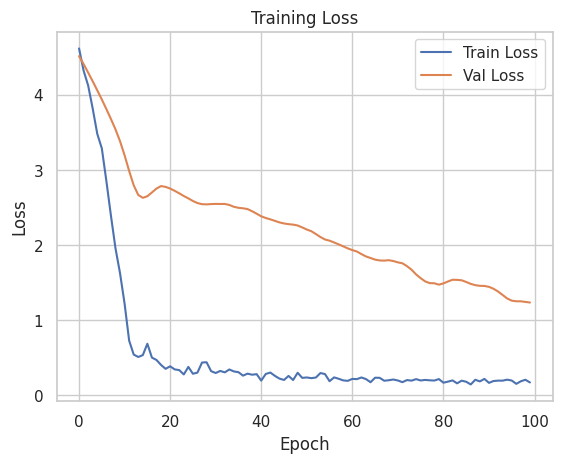

In [ ]:
# Improved Multi-Input Model with EfficientNetB0 Fine-Tuning and Feature Normalization

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# Paths
IMAGE_DIR = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/FaceGen/Modeller"
CSV_PATH = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/pain_labels.csv"

# Load and preprocess CSV
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip().str.replace(",", ".", regex=False)

emotion_features = [
    'FearRating', 'AngerRating', 'DisgustRating', 'HappinessRating',
    'SadnessRating', 'SurpriseRating', 'ThreatRating',
    'FearComp', 'AngerComp', 'DisgustComp', 'HappinessComp',
    'SadnessComp', 'SurpriseComp', 'ThreatComp'
]

face_features = [
    'Anger', 'Disgust', 'Fear', 'Sad', 'SmileClosed', 'SmileOpen', 'Surprise',
    'BlinkLeft', 'BlinkRIght', 'BrowDownLeft', 'BrowDownRight', 'BrowInLeft',
    'BrownInRight', 'BrowUpLeft', 'BrowUpRight', 'EarsOut', 'EpicanthicFold',
    'EyeSquintLeft', 'EyeSquintRight', 'LookDown', 'LookLeft', 'LookRight',
    'LookUp', 'aah', 'B,M,P', 'big aah', 'ch,J,sh', 'D,S,T', 'ee', 'eh', 'F,V',
    'i', 'K', 'N', 'oh', 'ooh,Q', 'R', 'th', 'W'
]
face_features = [col for col in face_features if col in df.columns]
df = df.dropna(subset=['ImageFile', 'PainRating'] + emotion_features + face_features)

# Load data
X_img, X_emotion, X_face, y, img_folder_names = [], [], [], [], []
for root, _, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.png')):
            img_path = os.path.join(root, file)
            img_name = file.split("_")[-1]
            label_row = df[df['ImageFile'] == img_name]
            if not label_row.empty:
                try:
                    img = load_img(img_path, target_size=(128, 128))
                    img_array = img_to_array(img) / 255.0
                    emotion_data = label_row[emotion_features].values[0]
                    face_data = label_row[face_features].values[0]
                    pain = label_row['PainRating'].values[0]
                    X_img.append(img_array)
                    X_emotion.append(emotion_data)
                    X_face.append(face_data)
                    y.append(pain)
                    folder_name = os.path.basename(os.path.dirname(img_path))
                    img_folder_names.append(folder_name)
                except Exception as e:
                    print(f"Error processing {file}: {e}")

X_img = np.array(X_img)
X_emotion = np.array(X_emotion)
X_face = np.array(X_face)
y = np.array(y)
img_folder_names = np.array(img_folder_names)

# Normalize emotion and face features
emo_scaler = StandardScaler()
face_scaler = StandardScaler()
X_emotion = emo_scaler.fit_transform(X_emotion)
X_face = face_scaler.fit_transform(X_face)

# Split by folder
all_folders = sorted(set(img_folder_names))
train_folders, temp_folders = train_test_split(all_folders, test_size=0.3, random_state=42)
val_folders, test_folders = train_test_split(temp_folders, test_size=0.5, random_state=42)

def split_by_folder(folders, img_folders, *arrays):
    results = [[] for _ in arrays]
    for i, folder in enumerate(img_folders):
        if folder in folders:
            for res, arr in zip(results, arrays):
                res.append(arr[i])
    return map(np.array, results)

X_img_train, X_emo_train, X_face_train, y_train = split_by_folder(train_folders, img_folder_names, X_img, X_emotion, X_face, y)
X_img_val, X_emo_val, X_face_val, y_val = split_by_folder(val_folders, img_folder_names, X_img, X_emotion, X_face, y)
X_img_test, X_emo_test, X_face_test, y_test = split_by_folder(test_folders, img_folder_names, X_img, X_emotion, X_face, y)

# Build model
img_input = Input(shape=(128,128,3), name='ImageInput')
x = preprocess_input(img_input)
base_model = EfficientNetB0(include_top=False, input_tensor=x, pooling='avg', weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

emotion_input = Input(shape=(len(emotion_features),), name='EmotionInput')
e = Dense(128, activation='relu')(emotion_input)
e = Dropout(0.2)(e)
e = Dense(64, activation='relu')(e)

face_input = Input(shape=(len(face_features),), name='FaceInput')
f = Dense(128, activation='relu')(face_input)
f = Dropout(0.2)(f)
f = Dense(64, activation='relu')(f)

combined = Concatenate()([x, e, f])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu')(z)
output = Dense(1, name='PainOutput')(z)

model = Model(inputs=[img_input, emotion_input, face_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=Huber(), metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(filepath='best_pain_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    [X_img_train, X_emo_train, X_face_train], y_train,
    validation_data=([X_img_val, X_emo_val, X_face_val], y_val),
    epochs=100, batch_size=32, callbacks=callbacks, verbose=1
)

# Evaluate
# Evaluate
print("\nEvaluating on test set:")
test_loss, test_mae = model.evaluate([X_img_test, X_emo_test, X_face_test], y_test)
y_pred = model.predict([X_img_test, X_emo_test, X_face_test])
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R²: {r2_score(y_test, y_pred):.4f} | RMSE: {rmse:.4f}")


# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


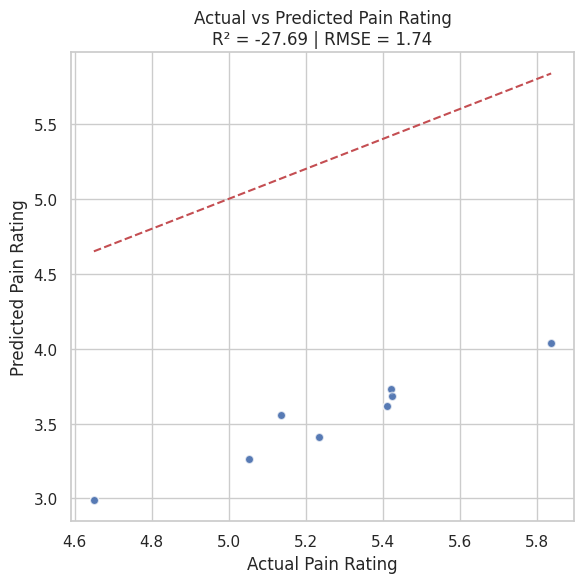

R² score: -27.6939 | RMSE: 1.7356


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict([X_img_test, X_emo_test, X_face_test])

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='w')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Pain Rating")
plt.ylabel("Predicted Pain Rating")
plt.title(f"Actual vs Predicted Pain Rating\nR² = {r2:.2f} | RMSE = {rmse:.2f}")
plt.grid(True)
plt.tight_layout()
plt.show()
print(f"R² score: {r2:.4f} | RMSE: {rmse:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


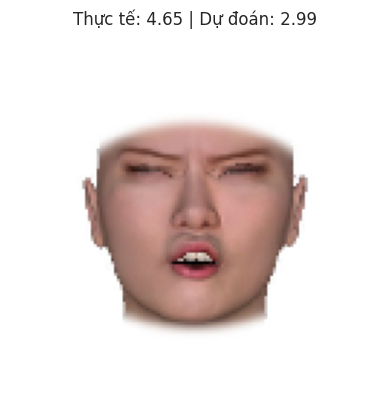

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


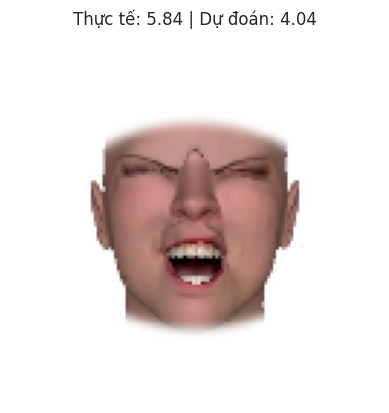

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


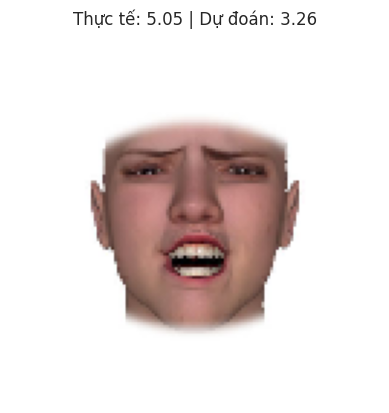

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


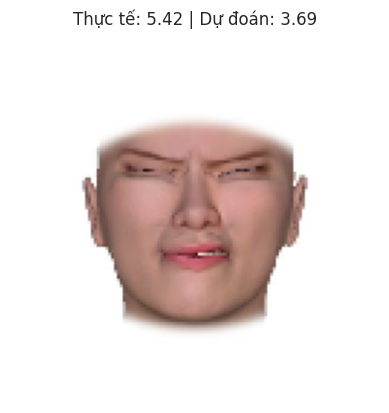

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


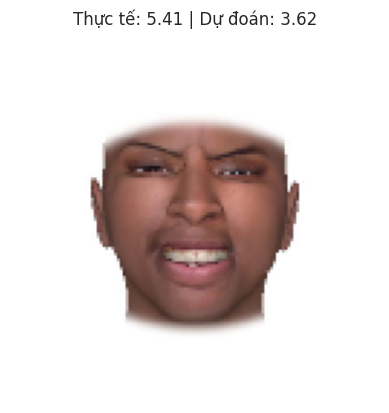

In [ ]:
import random

for _ in range(5):  # test 5 mẫu random
    idx = random.randint(0, len(X_img_test) - 1)
    img_sample = np.expand_dims(X_img_test[idx], axis=0)
    emo_sample = np.expand_dims(X_emo_test[idx], axis=0)
    face_sample = np.expand_dims(X_face_test[idx], axis=0)

    pred = model.predict([img_sample, emo_sample, face_sample])[0][0]

    plt.imshow(X_img_test[idx])
    plt.axis('off')
    plt.title(f"Thực tế: {y_test[idx]:.2f} | Dự đoán: {pred:.2f}")
    plt.show()


Chuyển merged_output.xlsx sang output.xlsx

In [ ]:
import pandas as pd

# Đường dẫn đến tệp .xlsx
input_file = '/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/merged_output.xlsx'  # Thay bằng đường dẫn tệp của bạn
output_file = '/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output.xlsx'  # Tên tệp .csv đầu ra


# Đọc tệp .xlsx
df = pd.read_excel(input_file)

df = df.drop(columns=['ResponseId'])

df.head()

# Lưu dưới dạng .csv
df.to_csv(output_file, index=False, encoding='utf-8')

print(f"Đã chuyển đổi {input_file} sang {output_file}")


Đã chuyển đổi /content/drive/MyDrive/dataset_osfstorage-archive/NormingData/merged_output.xlsx sang /content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output.xlsx


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# Tùy chỉnh để hiển thị biểu đồ đẹp hơn
sns.set(style="whitegrid")

Mounted at /content/drive


# **output.csv**

# **dùng tensorflow**

Sử dụng face_features: ['Anger', 'Disgust', 'Fear', 'Sad', 'SmileClosed', 'SmileOpen', 'Surprise', 'BlinkLeft', 'BlinkRIght', 'BrowDownLeft', 'BrowDownRight', 'BrowInLeft', 'BrownInRight', 'BrowUpLeft', 'BrowUpRight', 'EarsOut', 'EpicanthicFold', 'EyeSquintLeft', 'EyeSquintRight', 'LookDown', 'LookLeft', 'LookRight', 'LookUp', 'aah', 'big aah', 'ee', 'eh', 'i', 'K', 'N', 'oh', 'R', 'th', 'W']
Tổng ảnh hợp lệ: 128
Train: 88 | Val: 16 | Test: 24
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - loss: 4.4777 - mae: 4.9777
Epoch 1: val_loss improved from inf to 2.04431, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 4.3762 - mae: 4.8762 - val_loss: 2.0443 - val_mae: 2.5443 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - loss: 1.6358 - mae: 2.1017
Epoch 2: val_loss improved from 2.04431 to 0.44634, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 951ms/step - loss: 1.5448 - mae: 2.0045 - val_loss: 0.4463 - val_mae: 0.9238 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - loss: 1.2819 - mae: 1.7129
Epoch 3: val_loss improved from 0.44634 to 0.18149, saving model to best_pain_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 944ms/step - loss: 1.3153 - mae: 1.7480 - val_loss: 0.1815 - val_mae: 0.5484 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - loss: 0.8950 - mae: 1.3070
Epoch 4: val_loss did not improve from 0.18149
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.8788 - mae: 1.2907 - val_loss: 0.4631 - val_mae: 0.9324 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - loss: 0.8721 - mae: 1.3158
Epoch 5: val_loss did not improve from 0.18149
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 690ms/step - loss: 0.8739 - mae: 1.3170 - val_loss: 0.8930 - val_mae: 1.3907 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - loss: 0.7335 - mae: 1.1519
Epoch 6: val_loss did not improve from 0.18149
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 700ms/step - loss: 0.7334 - mae: 1.1534 - val_loss: 0.2483 - val_mae: 0.6583 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - loss: 0.8211 - mae: 1.2439
Epoch 7: val_loss improved

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 904ms/step - loss: 0.8332 - mae: 1.2591 - val_loss: 0.0292 - val_mae: 0.1764 - learning_rate: 0.0010
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - loss: 1.0490 - mae: 1.4768
Epoch 8: val_loss did not improve from 0.02920
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 1.0185 - mae: 1.4454 - val_loss: 0.2120 - val_mae: 0.6040 - learning_rate: 0.0010
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 0.6123 - mae: 1.0093
Epoch 9: val_loss did not improve from 0.02920
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 676ms/step - loss: 0.6024 - mae: 0.9978 - val_loss: 0.5648 - val_mae: 1.0492 - learning_rate: 0.0010
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - loss: 0.6449 - mae: 1.0544
Epoch 10: val_loss did not improve from 0.02920
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 716ms/step - loss: 0.6356 - mae: 1.0426 - val_loss: 0.4286 - val_mae: 0.8981 - learning_rate: 0.0010
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 0.6015 - mae: 0.9819
Epoch 11: val_loss did 

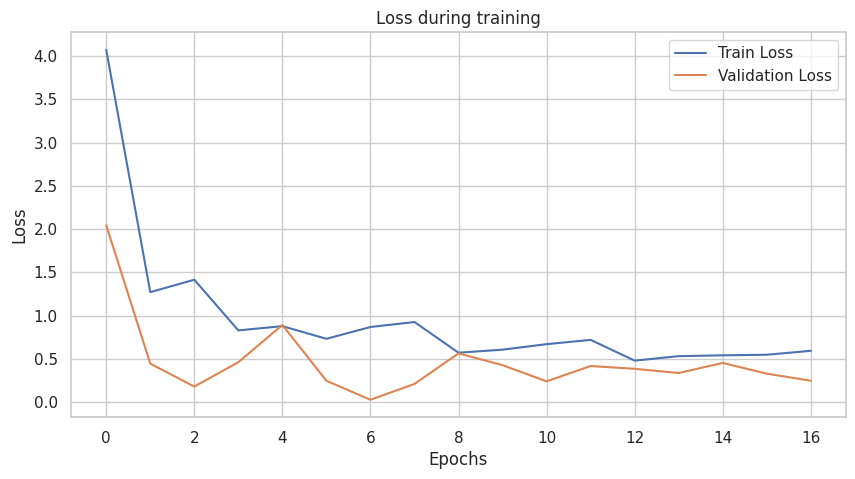

In [ ]:
import os  # Duyệt file và thư mục
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.losses import Huber

# BƯỚC 1: ĐƯỜNG DẪN
IMAGE_DIR = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/FaceGen/Modeller"
CSV_PATH = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output.csv"

# BƯỚC 2: ĐỌC CSV & CHUẨN HÓA
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(",", ".", regex=False)

emotion_features = [
    'FearRating', 'AngerRating', 'DisgustRating', 'HappinessRating',
    'SadnessRating', 'SurpriseRating', 'ThreatRating',
    'FearComp', 'AngerComp', 'DisgustComp', 'HappinessComp',
    'SadnessComp', 'SurpriseComp', 'ThreatComp'
]

face_features = [
    'Anger', 'Disgust', 'Fear', 'Sad', 'SmileClosed', 'SmileOpen', 'Surprise',
    'BlinkLeft', 'BlinkRIght', 'BrowDownLeft', 'BrowDownRight', 'BrowInLeft',
    'BrownInRight', 'BrowUpLeft', 'BrowUpRight', 'EarsOut', 'EpicanthicFold',
    'EyeSquintLeft', 'EyeSquintRight', 'LookDown', 'LookLeft', 'LookRight',
    'LookUp', 'aah', 'B,M,P', 'big aah', 'ch,J,sh', 'D,S,T', 'ee', 'eh', 'F,V',
    'i', 'K', 'N', 'oh', 'ooh,Q', 'R', 'th', 'W'
]
# Lọc các cột thực sự tồn tại
face_features = [col for col in face_features if col in df.columns]
print("Sử dụng face_features:", face_features)

df = df.dropna(subset=['ImageFile', 'PainRating'] + emotion_features + face_features)

# BƯỚC 3: LOAD DỮ LIỆU
X_img, X_emotion, X_face, y, img_folder_names = [], [], [], [], []
for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.png')):
            img_path = os.path.join(root, file)
            img_name = file
            if "_" in img_name:
                image_file_part = img_name.split("_")[-1]
                label_row = df[df['ImageFile'] == image_file_part]
                if not label_row.empty:
                    try:
                        img = load_img(img_path, target_size=(128, 128))
                        img_array = img_to_array(img) / 255.0
                        emotion_data = label_row[emotion_features].values[0]
                        face_data = label_row[face_features].values[0]
                        pain = label_row['PainRating'].values[0]
                        X_img.append(img_array)
                        X_emotion.append(emotion_data)
                        X_face.append(face_data)
                        y.append(pain)
                        folder_name = os.path.basename(os.path.dirname(img_path))
                        img_folder_names.append(folder_name)
                    except Exception as e:
                        print(f"❌ Lỗi xử lý ảnh {file}: {e}")

X_img = np.array(X_img)
X_emotion = np.array(X_emotion)
X_face = np.array(X_face)
y = np.array(y)
img_folder_names = np.array(img_folder_names)
print("Tổng ảnh hợp lệ:", len(X_img))

# BƯỚC 4: CHIA DỮ LIỆU (THEO THƯ MỤC)
all_folders = sorted(set(img_folder_names))
train_folders, temp_folders = train_test_split(all_folders, test_size=0.3, random_state=42)
val_folders, test_folders = train_test_split(temp_folders, test_size=0.5, random_state=42)

def split_by_folder(folders, img_folders, *arrays):
    results = [[] for _ in arrays]
    for i, folder in enumerate(img_folders):
        if folder in folders:
            for res, arr in zip(results, arrays): res.append(arr[i])
    return map(np.array, results)

X_img_train, X_emo_train, X_face_train, y_train = split_by_folder(train_folders, img_folder_names, X_img, X_emotion, X_face, y)
X_img_val, X_emo_val, X_face_val, y_val = split_by_folder(val_folders, img_folder_names, X_img, X_emotion, X_face, y)
X_img_test, X_emo_test, X_face_test, y_test = split_by_folder(test_folders, img_folder_names, X_img, X_emotion, X_face, y)
print("Train:", len(X_img_train), "| Val:", len(X_img_val), "| Test:", len(X_img_test))

# BƯỚC 5: XÂY DỰNG MÔ HÌNH (MULTI-INPUT)
img_input = Input(shape=(128,128,3), name='ImageInput')
x = preprocess_input(img_input)
base_model = EfficientNetB0(include_top=False, input_tensor=x, pooling='avg', weights='imagenet')
base_model.trainable = False
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

emotion_input = Input(shape=(len(emotion_features),), name='EmotionInput')
e = Dense(128, activation='relu')(emotion_input)
e = Dropout(0.3)(e)
e = Dense(64, activation='relu')(e)

face_input = Input(shape=(len(face_features),), name='FaceInput')
f = Dense(128, activation='relu')(face_input)
f = Dropout(0.3)(f)
f = Dense(64, activation='relu')(f)

combined = Concatenate()([x, e, f])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.4)(z)
z = Dense(64, activation='relu')(z)
z = Dropout(0.2)(z)
output = Dense(1, name='PainOutput')(z)

model = Model(inputs=[img_input, emotion_input, face_input], outputs=output)
model.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=['mae'])

# BƯỚC 6: TRAIN MÔ HÌNH
# Khởi tạo các callback để hỗ trợ quá trình huấn luyện:
# callbacks = [
#     EarlyStopping(
#         monitor='val_loss',    # Theo dõi giá trị validation loss
#         patience=10,           # Nếu 10 epoch liên tiếp không giảm -> dừng sớm
#         restore_best_weights=True  # Phục hồi lại trọng số tốt nhất
#     ),
#     ReduceLROnPlateau(
#         monitor='val_loss',    # Theo dõi giá trị validation loss
#         factor=0.5,            # Nếu loss không giảm, giảm learning rate đi 1/2
#         patience=5,            # Sau 5 epoch không cải thiện thì giảm
#         verbose=1              # In ra thông báo khi learning rate thay đổi
#     )
# ]

# Định nghĩa callbacks mới: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_pain_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Bắt đầu huấn luyện mô hình
history = model.fit(
    [X_img_train, X_emo_train, X_face_train], y_train,
    validation_data=([X_img_val, X_emo_val, X_face_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# BƯỚC 7: ĐÁNH GIÁ MÔ HÌNH
test_loss, test_mae = model.evaluate(
    [X_img_test, X_emo_test, X_face_test], y_test,
    verbose=1
)
print(f"Test Loss: {test_loss:.4f} | Test MAE: {test_mae:.4f}")

# BƯỚC 8: VẼ BIỂU ĐỒ LOSS/MAE
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Nếu cần vẽ thêm MAE, bạn cũng có thể thêm:
# plt.plot(history.history['mae'], label='Train MAE')
# plt.plot(history.history['val_mae'], label='Validation MAE')


In [ ]:
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Đường dẫn model và file CSV
model = load_model("best_pain_model.h5")
csv_path = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/output.csv"
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(",", ".", regex=False)

# Cấu hình lại tên cột cần thiết
emotion_features = [
    'FearRating', 'AngerRating', 'DisgustRating', 'HappinessRating',
    'SadnessRating', 'SurpriseRating', 'ThreatRating',
    'FearComp', 'AngerComp', 'DisgustComp', 'HappinessComp',
    'SadnessComp', 'SurpriseComp', 'ThreatComp'
]

face_features = [
    'Anger', 'Disgust', 'Fear', 'Sad', 'SmileClosed', 'SmileOpen', 'Surprise',
    'BlinkLeft', 'BlinkRIght', 'BrowDownLeft', 'BrowDownRight', 'BrowInLeft',
    'BrownInRight', 'BrowUpLeft', 'BrowUpRight', 'EarsOut', 'EpicanthicFold',
    'EyeSquintLeft', 'EyeSquintRight', 'LookDown', 'LookLeft', 'LookRight',
    'LookUp', 'aah', 'B,M,P', 'big aah', 'ch,J,sh', 'D,S,T', 'ee', 'eh', 'F,V',
    'i', 'K', 'N', 'oh', 'ooh,Q', 'R', 'th', 'W'
]

# # Emotion + face features
# emo = row[emotion_features].iloc[0].values.astype('float32').reshape(1, -1)
# face = row[face_features].iloc[0].values.astype('float32').reshape(1, -1)


# Chỉ chọn những cột thực sự có
face_features = [col for col in face_features if col in df.columns]


# ===============================
# ✅ FUNCTION: Dự đoán từ một ảnh
# ===============================
def predict_pain(image_path):
    # Tách tên ảnh
    image_name = image_path.split("/")[-1].split("_")[-1]

    # Tìm dòng tương ứng trong CSV
    row = df[df['ImageFile'] == image_name]
    if row.empty:
        print("❌ Không tìm thấy metadata cho ảnh:", image_name)
        return

    # Đọc ảnh bằng OpenCV
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    # Emotion + face features (chỉ lấy dòng đầu tiên nếu có nhiều dòng)
    emo = row[emotion_features].iloc[0].values.astype('float32').reshape(1, -1)
    face = row[face_features].iloc[0].values.astype('float32').reshape(1, -1)

    # 📌 In thông số biểu cảm khuôn mặt
    print("\n🔍 Thông số đặc trưng khuôn mặt:")
    for f in face_features:
        print(f"  {f:<20}: {row[f].values[0]}")

    # Dự đoán
    y_pred = model.predict([img, emo, face])
    print(f"\n📸 Ảnh: {image_name} → Dự đoán mức độ đau: {y_pred[0][0]:.3f}")




# ===============================
# 🧪 Ví dụ chạy
# ===============================
image_path = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/FaceGen/Modeller/AF1/AF1_EF5.jpg"
predict_pain(image_path)



🔍 Thông số đặc trưng khuôn mặt:
  Anger               : 0.84
  Disgust             : 0.87
  Fear                : 0.5125
  Sad                 : 1.0
  SmileClosed         : 0.46
  SmileOpen           : 0.13
  Surprise            : 0.5125
  BlinkLeft           : 0.5125
  BlinkRIght          : 0.5125
  BrowDownLeft        : 0.42
  BrowDownRight       : 0.42
  BrowInLeft          : 0.5125
  BrownInRight        : 0.5125
  BrowUpLeft          : 0.5125
  BrowUpRight         : 0.5125
  EarsOut             : 0.5125
  EpicanthicFold      : 0.5125
  EyeSquintLeft       : 0.38
  EyeSquintRight      : 0.39
  LookDown            : 0.5125
  LookLeft            : 0.5125
  LookRight           : 0.5125
  LookUp              : 0.5125
  aah                 : 1.0
  big aah             : 0.12
  ee                  : 0.5125
  eh                  : 0.5125
  i                   : 0.5125
  K                   : 0.5125
  N                   : 0.5125
  oh                  : 0.12
  R                   : 0.5125
 

In [ ]:
import random

for _ in range(5):  # test 5 mẫu random
    idx = random.randint(0, len(X_img_test) - 1)
    img_sample = np.expand_dims(X_img_test[idx], axis=0)
    emo_sample = np.expand_dims(X_emo_test[idx], axis=0)
    face_sample = np.expand_dims(X_face_test[idx], axis=0)

    pred = model.predict([img_sample, emo_sample, face_sample])[0][0]

    plt.imshow(X_img_test[idx])
    plt.axis('off')
    plt.title(f"Thực tế: {y_test[idx]:.2f} | Dự đoán: {pred:.2f}")
    plt.show()


# **Clean DelawarePainDatabase_StimulusCharacterization_forOSF.xlsx**


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# Tùy chỉnh để hiển thị biểu đồ đẹp hơn
sns.set(style="whitegrid")

file_path = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/DelawarePainDatabase_StimulusCharacterization_forOSF.xlsx"
xls = pd.ExcelFile(file_path)

Mounted at /content/drive


In [2]:
import pandas as pd

def clean_DPD_NormingData(df):
    # Xóa các cột không cần thiết
    df = df.drop(columns=[
        # Định danh / hành chính
        "Consent", "Race", "Race_Mode", "RaceGenderCode", "RaceMatch", "LaterEditCode",
        "CollectionSiteCode", "NeutralFilter", "NoExpsFilter", "LaterEditFilter", "PostedFilter", "Prompt",

        # Nhân khẩu học
        "Gender", "Age_Average", "Male", "Female", "White", "Black", "Hispanic", "EastAsian",
        "SouthAsian", "PacificIslander", "NativeAmerican", "Other",

        # Đánh giá chủ quan (trung tính)
        "Masculine_Neutral", "Feminine_Neutral", "BabyFaced_Neutral", "Trustworthy_Neutral",
        "Dominant_Neutral", "Attractive_Neutral", "Unusual_Neutral", "Strong_Neutral",
        "HighStatus_Neutral", "LowStatus_Neutral", "Competent_Neutral", "Intelligent_Neutral",

        # Đánh giá cảm xúc trung tính
        "Fearful_Neutral", "Angry_Neutral", "Disgusted_Neutral", "Happy_Neutral", "Sad_Neutral",
        "Surprised_Neutral", "Threatening_Neutral", "PhysicalPain_Neutral", "Neutral_Rating_Count",

        # Cảm xúc phụ không cần thiết
        "Next_Highest_Expression", "Expession_Highest", "ExpressionType", "Expression_Count",

        # Đánh giá chủ quan không có giá trị học máy
        "PainSpecificity", "HowBelievable", "HowPosed", "Race_Prototypicality",

        # Dữ liệu kỹ thuật không cần thiết
        "OpenFace_confidence"
    ], errors='ignore')  # Sử dụng 'ignore' để tránh lỗi nếu một số cột không có

    return df


In [18]:
df_RawNeutralData_DPD = pd.read_excel(xls, sheet_name="DPD_NormingData")
df_RawNeutralData_DPD = clean_DPD_NormingData(df_RawNeutralData_DPD)

df_RawNeutralData_DPD.columns.tolist()

# print(df_RawNeutralData_DPD["Target"].duplicated().to_string())

df_RawNeutralData_DPD.to_csv("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/DFD_NormingData1.csv", index=False)



/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
# df_NormingData = pd.read_excel(xls, sheet_name="DPD_NormingData")

# df_NormingData.to_csv("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/DFD_NormingData.csv", index=False)

# df_DPD_Codebook = pd.read_excel(xls, sheet_name="DPD_Codebook")
# df_DPD_Codebook.to_csv("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/DFD_Codebook.csv", index=False)

# df_RawNeutralData_DPD = pd.read_excel(xls, sheet_name="RawNeutralData_DPD")
# df_RawNeutralData_DPD.to_csv("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/RawNeutralData_DPD.csv", index=False)

# df_RawExpressionData_DPD = pd.read_excel(xls, sheet_name="RawExpressionData_DPD")
# df_RawExpressionData_DPD.to_csv("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/RawExpressionData_DPD.csv", index=False)

# df_RawAUData_Facs_vs_OpenFace = pd.read_excel(xls, sheet_name="RawAUData_Facs_vs_OpenFace")
# df_RawAUData_Facs_vs_OpenFace.to_csv("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/RawAUData_Facs_vs_OpenFace.csv", index=False)

In [6]:
# Mô hình dự đoán mức độ đau từ ảnh neutral + expression + AU/biểu cảm
import re
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Cài đặt ===
NEUTRAL_DIR = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/Neutral Images/Unedited"
EXPRESSION_DIR = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/Expression Images/Unedited"
LABEL_FILE = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/DFD_NormingData1.csv"
BATCH_SIZE = 16
IMG_SIZE = 224

# === Tiền xử lý ===
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === Dataset ===
# === LỚP PainDataset - PHIÊN BẢN DỌN DẸP DỮ LIỆU TRIỆT ĐỂ ===
class PainDataset(Dataset):
    def __init__(self, neutral_dir, expression_dir, label_file, transform=None):
        self.transform = transform

        # 1. Quét và tạo bản đồ đường dẫn
        self.neutral_path_map = {os.path.basename(p).lower(): p for p in self._find_all_images(neutral_dir)}
        self.expression_path_map = {os.path.basename(p).lower(): p for p in self._find_all_images(expression_dir)}

        # 2. Đọc file label
        labels_df = pd.read_csv(label_file)

        # --- BƯỚC 3: DỌN DẸP DỮ LIỆU (QUAN TRỌNG) ---
        # Liệt kê tất cả các cột cần phải là số
        au_cols = [f"AU{i:02}_OF" for i in [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 17, 20, 23, 25, 26, 28, 45]]
        numeric_cols = au_cols + ["Pain_Expression", "PhysicalPain_Neutral"]

        for col in numeric_cols:
            if col in labels_df.columns:
                # Bước 3.1: Thay thế dấu phẩy bằng dấu chấm
                labels_df[col] = labels_df[col].astype(str).str.replace(',', '.')
                # Bước 3.2: Ép chuyển đổi sang dạng số. Mọi giá trị lỗi sẽ thành NaN (Not a Number)
                labels_df[col] = pd.to_numeric(labels_df[col], errors='coerce')

        # Bước 3.3: Thay thế tất cả các giá trị NaN (lỗi) bằng số 0
        labels_df = labels_df.fillna(0)
        # --- KẾT THÚC DỌN DẸP DỮ LIỆU ---

        # Bây giờ, lọc các hàng không cần thiết
        labels_df = labels_df.dropna(subset=["Target"])

        # 4. Tạo và suy ra tên tệp
        labels_df["Expression_File"] = labels_df["Target"].apply(lambda x: str(x).strip() + ".jpg").str.lower()

        def get_neutral_name(expression_filename):
            base_name = re.sub(r'_p\dc$', '', os.path.splitext(expression_filename)[0])
            return base_name + '.jpg'
        labels_df["Neutral_File"] = labels_df["Expression_File"].apply(get_neutral_name)

        # 5. Lọc để giữ lại những dòng có cặp ảnh tồn tại
        self.labels = labels_df[
            labels_df["Expression_File"].isin(self.expression_path_map.keys()) &
            labels_df["Neutral_File"].isin(self.neutral_path_map.keys())
        ].reset_index(drop=True)

        print(f"Đã tìm thấy {len(self.labels)} cặp ảnh (Neutral + Expression) hợp lệ để đưa vào mô hình.")

    def _find_all_images(self, root_dir):
        # ... (Hàm này giữ nguyên, không thay đổi)
        image_paths = []
        if not os.path.isdir(root_dir):
            print(f"CẢNH BÁO: Thư mục không tồn tại: {root_dir}")
            return []
        for dirpath, _, filenames in os.walk(root_dir):
            for filename in filenames:
                if filename.upper().endswith(('.JPG', '.JPEG', '.PNG')):
                    image_paths.append(os.path.join(dirpath, filename))
        return image_paths

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # DỮ LIỆU ĐÃ SẠCH, HÀM NÀY GIỜ RẤT ĐƠN GIẢN
        row = self.labels.iloc[idx]

        neutral_filename = row["Neutral_File"]
        expression_filename = row["Expression_File"]

        neutral_path = self.neutral_path_map[neutral_filename]
        expression_path = self.expression_path_map[expression_filename]

        neutral_img = Image.open(neutral_path).convert("RGB")
        expr_img = Image.open(expression_path).convert("RGB")

        if self.transform:
            neutral_img = self.transform(neutral_img)
            expr_img = self.transform(expr_img)

        combined_img = torch.cat([neutral_img, expr_img], dim=0)

        # Lấy giá trị trực tiếp vì đã được dọn dẹp
        au_values = [row.get(f"AU{i:02}_OF", 0) for i in [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 17, 20, 23, 25, 26, 28, 45]]
        aus = torch.tensor(au_values, dtype=torch.float)

        pain_score = torch.tensor(row["Pain_Expression"], dtype=torch.float)

        return combined_img, aus, pain_score

def collate_fn(batch):
    # Lọc ra các mẫu bị lỗi (None)
    batch = list(filter(lambda x: x[0] is not None, batch))
    if not batch:
        return torch.Tensor(), torch.Tensor(), torch.Tensor()
    return torch.utils.data.dataloader.default_collate(batch)

# === Mô hình ===
class PainNet(nn.Module):
    def __init__(self):
        super(PainNet, self).__init__()
        base_model = resnet18(pretrained=True)
        base_model.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  # Output: (B, 512, 1, 1)

        self.fc = nn.Sequential(
            nn.Linear(512 + 18, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x_img, x_au):
        x_feat = self.feature_extractor(x_img).view(x_img.size(0), -1)
        x = torch.cat([x_feat, x_au], dim=1)
        return self.fc(x)

# === Huấn luyện ===
def train_model():
    # 1. Tải và chia toàn bộ dữ liệu
    full_dataset = PainDataset(NEUTRAL_DIR, EXPRESSION_DIR, LABEL_FILE, transform=transform)

    # Chia dữ liệu: 80% cho train, 20% cho validation
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    print(f"Kích thước tập Train: {len(train_dataset)}")
    print(f"Kích thước tập Validation: {len(val_dataset)}")

    # 2. Tạo DataLoader cho từng tập
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn) # Val không cần shuffle

    # 3. Khởi tạo mô hình, hàm loss, và optimizer
    model = PainNet()
    # model = model.cuda() if torch.cuda.is_available() else model
    model.to(device)
    criterion = nn.MSELoss()
    # Sửa lại dòng optimizer của bạn
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # Thêm weight_decay
    # Thêm scheduler ngay sau optimizer
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2, verbose=True)

    best_val_loss = float('inf') # Khởi tạo val loss tốt nhất ở vô cực
    epochs_no_improve = 0 # Đếm số epoch không cải thiện
    n_epochs_stop = 3 # Dừng nếu val loss không cải thiện trong 3 epoch

    # 4. Vòng lặp huấn luyện và kiểm định
    for epoch in range(10):
        # --- PHA HUẤN LUYỆN ---
        model.train() # Chuyển sang chế độ train
        running_train_loss = 0.0
        for imgs, aus, scores in train_loader:
            # imgs, aus, scores = imgs.cuda(), aus.cuda(), scores.cuda()
            imgs, aus, scores = imgs.to(device), aus.to(device), scores.to(device) # THAY .cuda() BẰNG .to(device)

            optimizer.zero_grad()
            outputs = model(imgs, aus).squeeze()
            loss = criterion(outputs, scores)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        # --- PHA KIỂM ĐỊNH (VALIDATION) ---
        model.eval() # Chuyển sang chế độ eval
        running_val_loss = 0.0
        with torch.no_grad(): # Không tính gradient trong pha validation
            for imgs, aus, scores in val_loader:
                # imgs, aus, scores = imgs.cuda(), aus.cuda(), scores.cuda()
                imgs, aus, scores = imgs.to(device), aus.to(device), scores.to(device) # THAY .cuda() BẰNG .to(device)
                outputs = model(imgs, aus).squeeze()
                loss = criterion(outputs, scores)
                running_val_loss += loss.item()

        # In kết quả của epoch
        avg_train_loss = running_train_loss / len(train_loader)
        avg_val_loss = running_val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch+1}/{10} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # --- LOGIC CỦA EARLY STOPPING ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth') # Lưu lại mô hình tốt nhất
            print(f"Validation loss decreased. Saving model to 'best_model.pth'")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= n_epochs_stop:
                print(f"Early stopping triggered after {n_epochs_stop} epochs with no improvement.")
                break # Dừng vòng lặp huấn luyện

    print("Training finished.")

if __name__ == '__main__':
    train_model()


Using device: cpu
Đã tìm thấy 477 cặp ảnh (Neutral + Expression) hợp lệ để đưa vào mô hình.
Kích thước tập Train: 381
Kích thước tập Validation: 96


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Loss: 3.8298 | Val Loss: 1.6609
Validation loss decreased. Saving model to 'best_model.pth'
Epoch 2/10 | Train Loss: 0.9994 | Val Loss: 1.1419
Validation loss decreased. Saving model to 'best_model.pth'
Epoch 3/10 | Train Loss: 0.8655 | Val Loss: 1.0728
Validation loss decreased. Saving model to 'best_model.pth'
Epoch 4/10 | Train Loss: 0.7141 | Val Loss: 0.9358
Validation loss decreased. Saving model to 'best_model.pth'
Epoch 5/10 | Train Loss: 0.5563 | Val Loss: 1.0761
Epoch 6/10 | Train Loss: 0.5469 | Val Loss: 0.8839
Validation loss decreased. Saving model to 'best_model.pth'
Epoch 7/10 | Train Loss: 0.6085 | Val Loss: 0.9741
Epoch 8/10 | Train Loss: 0.6224 | Val Loss: 0.9868
Epoch 9/10 | Train Loss: 0.5089 | Val Loss: 0.9946
Early stopping triggered after 3 epochs with no improvement.
Training finished.


In [ ]:
# -*- coding: utf-8 -*-
"""
Mô hình dự đoán mức độ đau - Phiên bản đơn giản hóa,
chỉ dùng DFD_NormingData.csv cho nhãn và AU.
"""

# === 1. IMPORTS ===
import re
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === 2. CÀI ĐẶT TOÀN CỤC ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng device: {device}")

# --- Đường dẫn đến các thư mục và file ---
UNEDITED_NEUTRAL_DIR = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/Neutral Images/Unedited"
UNEDITED_EXPRESSION_DIR = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/Expression Images/Unedited"
CROPPED_NEUTRAL_DIR = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/Neutral Images/Cropped and Standardized"
CROPPED_EXPRESSION_DIR = "/content/drive/MyDrive/dataset_osfstorage-archive/Stimuli/Expression Images/Cropped and Standardized"

# Chỉ sử dụng file này cho cả nhãn và AU
LABELS_AND_AU_PATH = "/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/DFD_NormingData.csv"

# --- Các siêu tham số ---
BATCH_SIZE = 16
IMG_SIZE = 224
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 30

# === 3. TIỀN XỬ LÝ ẢNH ===
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === 4. ĐỊNH NGHĨA DATASET ===
class PainDataset(Dataset):
    def __init__(self,
                 unedited_neutral_dir, unedited_expression_dir,
                 cropped_neutral_dir, cropped_expression_dir,
                 labels_and_au_path,
                 transform=None):

        self.transform = transform

        print("--- BẮT ĐẦU KHỞI TẠO PainDataset ---")
        print("Đang quét các thư mục ảnh...")

        # 1. Quét ảnh và tạo bản đồ đường dẫn
        #    KEY của map bây giờ là TÊN FILE GỐC (không có đuôi), chữ thường
        self.unedited_neutral_map = {os.path.splitext(os.path.basename(p))[0].lower(): p for p in self._find_all_images(unedited_neutral_dir)}
        print(f"Tìm thấy {len(self.unedited_neutral_map)} ảnh trong Unedited Neutral.")
        self.unedited_expression_map = {os.path.splitext(os.path.basename(p))[0].lower(): p for p in self._find_all_images(unedited_expression_dir)}
        print(f"Tìm thấy {len(self.unedited_expression_map)} ảnh trong Unedited Expression.")

        self.cropped_neutral_map = {os.path.splitext(os.path.basename(p))[0].lower(): p for p in self._find_all_images(cropped_neutral_dir)}
        print(f"Tìm thấy {len(self.cropped_neutral_map)} ảnh trong Cropped Neutral.")
        self.cropped_expression_map = {os.path.splitext(os.path.basename(p))[0].lower(): p for p in self._find_all_images(cropped_expression_dir)}
        print(f"Tìm thấy {len(self.cropped_expression_map)} ảnh trong Cropped Expression.")

        # In ra vài key mẫu để kiểm tra
        print("\nDEBUG: Vài tên file mẫu từ self.cropped_neutral_map (keys là tên gốc, không đuôi):")
        if self.cropped_neutral_map: print(list(self.cropped_neutral_map.keys())[:5])
        print("DEBUG: Vài tên file mẫu từ self.cropped_expression_map (keys là tên gốc, không đuôi):")
        if self.cropped_expression_map: print(list(self.cropped_expression_map.keys())[:5])

        print(f"\nĐang đọc và xử lý dữ liệu từ file: {labels_and_au_path}")
        try:
            labels_df = pd.read_csv(labels_and_au_path)
        except FileNotFoundError as e:
            print(f"LỖI: Không tìm thấy file CSV: {e}"); self.labels = pd.DataFrame(); return

        labels_df.columns = labels_df.columns.str.strip()

        au_indices = [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 17, 20, 23, 25, 26, 28, 45]
        au_cols_to_clean = [f"AU{i:02d}_OF" for i in au_indices]
        numeric_cols_to_clean = au_cols_to_clean + ["Pain_Expression", "PhysicalPain_Neutral"]

        for col in numeric_cols_to_clean:
            if col in labels_df.columns:
                labels_df[col] = labels_df[col].astype(str).str.replace(',', '.')
                labels_df[col] = pd.to_numeric(labels_df[col], errors='coerce')
        labels_df = labels_df.fillna(0)

        labels_df = labels_df.dropna(subset=["Target"])
        if 'Target' not in labels_df.columns:
             print(f"LỖI NGHIÊM TRỌNG: Cột 'Target' không tồn tại trong file {labels_and_au_path}."); self.labels = pd.DataFrame(); return

        print(f"Số lượng dòng trong file CSV sau khi đọc và lọc 'Target' rỗng: {len(labels_df)}")

        # Tạo TÊN FILE GỐC (không có đuôi) từ cột Target
        labels_df["Expression_Base_File"] = labels_df["Target"].apply(lambda x: str(x).strip()).str.lower()
        def get_neutral_base_name(expression_base_filename):
            return re.sub(r'_p\dc$', '', expression_base_filename)
        labels_df["Neutral_Base_File"] = labels_df["Expression_Base_File"].apply(get_neutral_base_name)

        print("\nDEBUG: Vài tên file GỐC (không đuôi) được suy ra từ CSV:")
        print(labels_df[['Target', 'Expression_Base_File', 'Neutral_Base_File']].head())

        print("\nĐang lọc các cặp ảnh hợp lệ...")
        unedited_df = labels_df[
            labels_df["Expression_Base_File"].isin(self.unedited_expression_map.keys()) &
            labels_df["Neutral_Base_File"].isin(self.unedited_neutral_map.keys())
        ].copy()
        unedited_df['image_type'] = 'unedited'
        print(f"Tìm thấy {len(unedited_df)} cặp ảnh Unedited hợp lệ.")

        cropped_df = labels_df[
            labels_df["Expression_Base_File"].isin(self.cropped_expression_map.keys()) &
            labels_df["Neutral_Base_File"].isin(self.cropped_neutral_map.keys())
        ].copy()
        cropped_df['image_type'] = 'cropped'
        print(f"Tìm thấy {len(cropped_df)} cặp ảnh Cropped hợp lệ.")

        self.labels = pd.concat([unedited_df, cropped_df], ignore_index=True)
        print(f"\n--- TẠO DATASET THÀNH CÔNG ---")
        print(f"Tổng số mẫu trong dataset cuối cùng (bao gồm cả 2 bộ ảnh): {len(self.labels)}")

    def _find_all_images(self, root_dir):
        image_paths = []
        if not os.path.isdir(root_dir): print(f"CẢNH BÁO: Thư mục không tồn tại: {root_dir}"); return []
        for dirpath, _, filenames in os.walk(root_dir):
            for filename in filenames:
                # Hàm này vẫn tìm tất cả các đuôi ảnh hợp lệ
                if filename.upper().endswith(('.JPG', '.JPEG', '.PNG')):
                    image_paths.append(os.path.join(dirpath, filename))
        return image_paths

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labels.iloc[idx]
        image_type = row["image_type"]

        # Sử dụng tên file GỐC (không đuôi) để lấy đường dẫn
        neutral_base_filename = row["Neutral_Base_File"]
        expression_base_filename = row["Expression_Base_File"]

        if image_type == 'unedited':
            neutral_path = self.unedited_neutral_map[neutral_base_filename]
            expression_path = self.unedited_expression_map[expression_base_filename]
        else: # 'cropped'
            neutral_path = self.cropped_neutral_map[neutral_base_filename]
            expression_path = self.cropped_expression_map[expression_base_filename]

        neutral_img, expr_img = Image.open(neutral_path).convert("RGB"), Image.open(expression_path).convert("RGB")
        if self.transform:
            neutral_img, expr_img = self.transform(neutral_img), self.transform(expr_img)

        combined_img = torch.cat([neutral_img, expr_img], dim=0)
        au_values = [row.get(f"AU{i:02d}_OF", 0) for i in [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 17, 20, 23, 25, 26, 28, 45]]
        aus = torch.tensor(au_values, dtype=torch.float)
        pain_score = torch.tensor(row["Pain_Expression"], dtype=torch.float)
        return combined_img, aus, pain_score

# === 5. ĐỊNH NGHĨA CÁC HÀM TIỆN ÍCH VÀ MÔ HÌNH ===
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None and x[0] is not None, batch))
    if not batch: return torch.Tensor(), torch.Tensor(), torch.Tensor()
    return torch.utils.data.dataloader.default_collate(batch)

class PainNet(nn.Module):
    def __init__(self):
        super(PainNet, self).__init__()
        base_model = resnet18(pretrained=True)
        base_model.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(512 + 18, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1)
        )
    def forward(self, x_img, x_au):
        x_feat = self.feature_extractor(x_img).view(x_img.size(0), -1)
        x = torch.cat([x_feat, x_au], dim=1)
        return self.fc(x)

# === 6. HÀM HUẤN LUYỆN ===
def train_model():
    print("\n--- BẮT ĐẦU QUÁ TRÌNH HUẤN LUYỆN ---")
    torch.manual_seed(42)

    full_dataset = PainDataset(
        unedited_neutral_dir=UNEDITED_NEUTRAL_DIR, unedited_expression_dir=UNEDITED_EXPRESSION_DIR,
        cropped_neutral_dir=CROPPED_NEUTRAL_DIR, cropped_expression_dir=CROPPED_EXPRESSION_DIR,
        labels_and_au_path=LABELS_AND_AU_PATH, # Chỉ còn 1 file CSV
        transform=transform
    )
    if len(full_dataset) == 0:
        print("LỖI: Dataset rỗng sau khi xử lý. Kết thúc huấn luyện.")
        return

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    if train_size == 0 or val_size == 0:
        print(f"LỖI: Không đủ dữ liệu để chia train/val. Train: {train_size}, Val: {val_size}")
        return

    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    print(f"Kích thước tập Train: {len(train_dataset)}, Kích thước tập Validation: {len(val_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = PainNet().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, verbose=True)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    n_epochs_stop = 5

    for epoch in range(EPOCHS):
        model.train()
        running_train_loss = 0.0
        if len(train_loader) == 0: print("CẢNH BÁO: train_loader rỗng!"); break
        for imgs, aus, scores in train_loader:
            if imgs.nelement() == 0: continue
            imgs, aus, scores = imgs.to(device), aus.to(device), scores.to(device)
            optimizer.zero_grad()
            outputs = model(imgs, aus).squeeze()
            loss = criterion(outputs, scores)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        model.eval()
        running_val_loss = 0.0
        if len(val_loader) == 0: print("CẢNH BÁO: val_loader rỗng!"); break
        with torch.no_grad():
            for imgs, aus, scores in val_loader:
                if imgs.nelement() == 0: continue
                imgs, aus, scores = imgs.to(device), aus.to(device), scores.to(device)
                outputs = model(imgs, aus).squeeze()
                loss = criterion(outputs, scores)
                running_val_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader) if len(train_loader) > 0 else 0
        avg_val_loss = running_val_loss / len(val_loader) if len(val_loader) > 0 else float('inf')

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:02d}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {current_lr:.1e}")

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"   -> Val loss decreased ({best_val_loss:.4f}). Saving model to 'best_model.pth'")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"   -> Val loss did not improve for {epochs_no_improve} epoch(s). Best: {best_val_loss:.4f}")
            if epochs_no_improve >= n_epochs_stop:
                print(f"   -> Early stopping triggered after {n_epochs_stop} epochs with no improvement.")
                break

    print("--- HUẤN LUYỆN KẾT THÚC ---")

# === 7. HÀM ĐÁNH GIÁ ===
def evaluate_model():
    print("\n--- BẮT ĐẦU ĐÁNH GIÁ MÔ HÌNH TỐT NHẤT ---")
    torch.manual_seed(42)
    full_dataset = PainDataset(
        unedited_neutral_dir=UNEDITED_NEUTRAL_DIR, unedited_expression_dir=UNEDITED_EXPRESSION_DIR,
        cropped_neutral_dir=CROPPED_NEUTRAL_DIR, cropped_expression_dir=CROPPED_EXPRESSION_DIR,
        labels_and_au_path=LABELS_AND_AU_PATH, # Chỉ còn 1 file CSV
        transform=transform
    )
    if len(full_dataset) == 0: print("LỖI: Dataset rỗng. Không thể đánh giá."); return

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    if train_size == 0 or val_size == 0:
        print(f"LỖI: Không đủ dữ liệu để chia train/val cho đánh giá. Train: {train_size}, Val: {val_size}")
        return

    _, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    model = PainNet().to(device)
    try:
        model.load_state_dict(torch.load('best_model.pth', map_location=device))
        print("Đã tải thành công mô hình từ 'best_model.pth'.")
    except FileNotFoundError:
        print("LỖI: Không tìm thấy file 'best_model.pth'. Không thể đánh giá.")
        return
    model.eval()

    all_labels, all_predictions = [], []
    if len(val_loader) == 0: print("CẢNH BÁO: val_loader rỗng trong hàm đánh giá!"); return

    with torch.no_grad():
        for imgs, aus, scores in val_loader:
            if imgs.nelement() == 0: continue
            imgs, aus, scores = imgs.to(device), aus.to(device), scores.to(device)
            outputs = model(imgs, aus).squeeze()
            all_labels.extend(scores.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    if not all_labels or not all_predictions:
        print("LỖI: Không có dữ liệu để tính toán chỉ số sau khi duyệt val_loader.")
        return

    mse, mae, r2 = mean_squared_error(all_labels, all_predictions), mean_absolute_error(all_labels, all_predictions), r2_score(all_labels, all_predictions)
    print("\n--- CÁC CHỈ SỐ ĐÁNH GIÁ ---")
    print(f"  - R-squared (R²): {r2:.4f}")
    print(f"  - RMSE: {np.sqrt(mse):.4f}")
    print(f"  - MAE: {mae:.4f}")

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(9, 9))
    plt.scatter(all_labels, all_predictions, alpha=0.6, edgecolors='k', s=50, label='Dữ liệu dự đoán')

    if all_labels and all_predictions:
        plot_lims_min = min(min(all_labels), min(all_predictions))
        plot_lims_max = max(max(all_labels), max(all_predictions))
        plot_lims = [plot_lims_min, plot_lims_max]
        plt.plot(plot_lims, plot_lims, 'r--', alpha=0.8, lw=2, label='Dự đoán hoàn hảo (y=x)')

    plt.xlabel("Giá trị thực tế", fontsize=13)
    plt.ylabel("Giá trị dự đoán", fontsize=13)
    plt.title("So sánh giá trị thực tế và giá trị dự đoán", fontsize=15, pad=15)
    plt.legend(fontsize=11)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# === 8. CHẠY CHƯƠNG TRÌNH ===
if __name__ == '__main__':
    train_model()
    evaluate_model()

Sử dụng device: cpu

--- BẮT ĐẦU QUÁ TRÌNH HUẤN LUYỆN ---
--- BẮT ĐẦU KHỞI TẠO PainDataset ---
Đang quét các thư mục ảnh...
Tìm thấy 219 ảnh trong Unedited Neutral.
Tìm thấy 584 ảnh trong Unedited Expression.
Tìm thấy 244 ảnh trong Cropped Neutral.
Tìm thấy 652 ảnh trong Cropped Expression.

DEBUG: Vài tên file mẫu từ self.cropped_neutral_map (keys là tên gốc, không đuôi):
['dpd_1_wm1', 'dpd_1_wm19', 'dpd_1_wm29', 'dpd_1_wm1alt', 'dpd_1_wm21']
DEBUG: Vài tên file mẫu từ self.cropped_expression_map (keys là tên gốc, không đuôi):
['dpd_1_wm3_p4', 'dpd_1_wm5_p1', 'dpd_1_wm1_p1', 'dpd_1_wm2_p4', 'dpd_1_wm5_p3']

Đang đọc và xử lý dữ liệu từ file: /content/drive/MyDrive/dataset_osfstorage-archive/NormingData/DFD_NormingData.csv
Số lượng dòng trong file CSV sau khi đọc và lọc 'Target' rỗng: 730

DEBUG: Vài tên file GỐC (không đuôi) được suy ra từ CSV:
                   Target    Expression_Base_File   Neutral_Base_File
0           DPD_1_OF8_p2c           dpd_1_of8_p2c           dpd_1_of8
1 

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will

Epoch 01/30 | Train Loss: 3.6023 | Val Loss: 0.9344 | LR: 1.0e-04
   -> Val loss decreased (0.9344). Saving model to 'best_model.pth'
Epoch 02/30 | Train Loss: 1.3006 | Val Loss: 0.8432 | LR: 1.0e-04
   -> Val loss decreased (0.8432). Saving model to 'best_model.pth'
Epoch 03/30 | Train Loss: 0.8250 | Val Loss: 0.8920 | LR: 1.0e-04
   -> Val loss did not improve for 1 epoch(s). Best: 0.8432


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/dataset_osfstorage-archive/NormingData/RawAUData_Facs_vs_OpenFace.csv")
df.head()


--- BẮT ĐẦU ĐÁNH GIÁ MÔ HÌNH ---
Sử dụng device để đánh giá: cpu
Đã tìm thấy 477 cặp ảnh (Neutral + Expression) hợp lệ để đưa vào mô hình.
Đã tải lại tập validation với 96 mẫu.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Đã tải thành công mô hình từ 'best_model.pth'.

--- CÁC CHỈ SỐ ĐÁNH GIÁ ---
Mean Squared Error (MSE):      0.3670
Root Mean Squared Error (RMSE):0.6058
Mean Absolute Error (MAE):     0.4255
R-squared (R²):                0.6345


<ipython-input-7-fd60edae8b37>:93: UserWarning: Glyph 7883 (\N{LATIN SMALL LETTER I WITH DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-7-fd60edae8b37>:93: UserWarning: Glyph 7921 (\N{LATIN SMALL LETTER U WITH HORN AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-7-fd60edae8b37>:93: UserWarning: Glyph 7871 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-7-fd60edae8b37>:93: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-7-fd60edae8b37>:93: UserWarning: Glyph 7919 (\N{LATIN SMALL LETTER U WITH HORN AND TILDE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-7-fd60edae8b37>:93: UserWarning: Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.

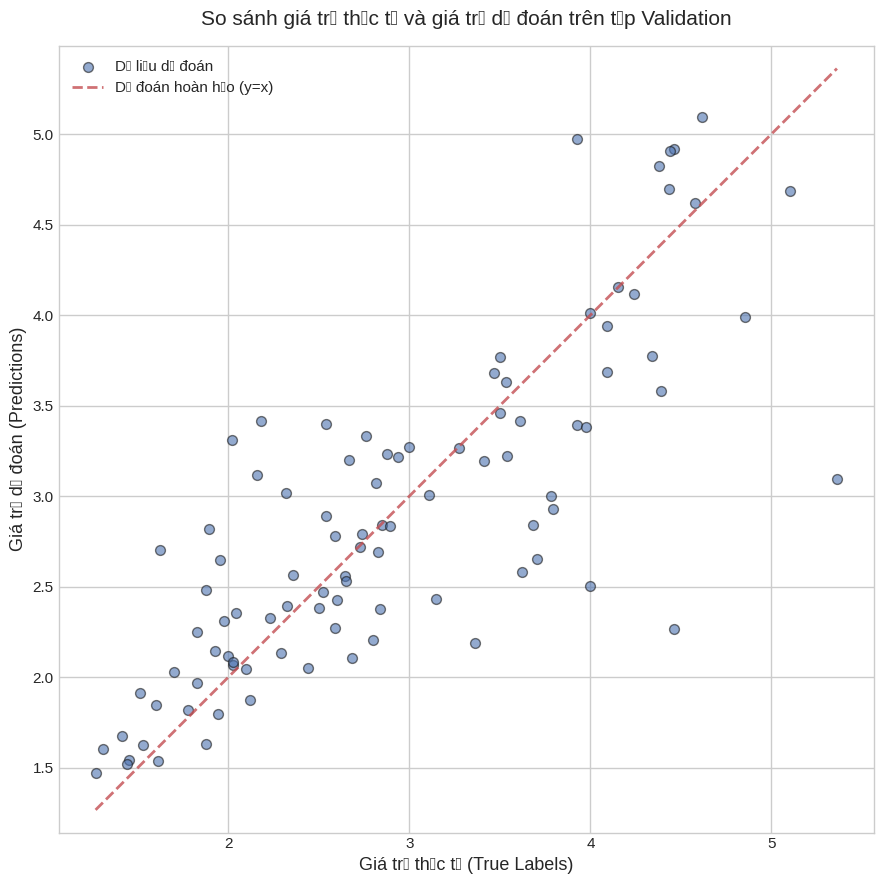

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import torch
from torch.utils.data import DataLoader

# --- HÀM ĐÁNH GIÁ MÔ HÌNH ---

def evaluate_model():
    """
    Tải mô hình tốt nhất đã lưu, chạy đánh giá trên tập validation,
    tính toán các chỉ số và vẽ biểu đồ kết quả.
    """
    print("\n--- BẮT ĐẦU ĐÁNH GIÁ MÔ HÌNH ---")

    # Tự động chọn device (CPU hoặc GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Sử dụng device để đánh giá: {device}")

    # --- 1. TẢI LẠI TẬP DỮ LIỆU VALIDATION ---
    # Đặt seed để đảm bảo việc chia train/val giống hệt như lúc huấn luyện
    # Rất quan trọng để có kết quả đánh giá chính xác
    torch.manual_seed(42)

    # Tải lại toàn bộ dataset
    # Giả định các biến NEUTRAL_DIR, EXPRESSION_DIR, LABEL_FILE, transform đã được định nghĩa ở các ô trước
    full_dataset = PainDataset(NEUTRAL_DIR, EXPRESSION_DIR, LABEL_FILE, transform=transform)

    # Chia lại y hệt như cũ để lấy đúng tập validation
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    _, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    print(f"Đã tải lại tập validation với {len(val_dataset)} mẫu.")

    # --- 2. TẢI MÔ HÌNH ĐÃ LƯU ---
    # Khởi tạo lại kiến trúc mô hình (giả định lớp PainNet đã được định nghĩa ở ô trước)
    model = PainNet()

    # Tải trọng số từ file best_model.pth
    # map_location=device đảm bảo code chạy được trên cả CPU và GPU
    try:
        model.load_state_dict(torch.load('best_model.pth', map_location=device))
    except FileNotFoundError:
        print("LỖI: Không tìm thấy file 'best_model.pth'. Vui lòng chạy ô huấn luyện trước.")
        return

    model.to(device)
    model.eval() # Chuyển mô hình sang chế độ đánh giá
    print("Đã tải thành công mô hình từ 'best_model.pth'.")

    # --- 3. LẤY DỰ ĐOÁN TỪ MÔ HÌNH ---
    all_labels = []
    all_predictions = []

    with torch.no_grad(): # Tắt việc tính gradient
        for imgs, aus, scores in val_loader:
            imgs, aus, scores = imgs.to(device), aus.to(device), scores.to(device)

            outputs = model(imgs, aus).squeeze()

            # Chuyển dữ liệu về CPU và gộp vào danh sách
            all_labels.extend(scores.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    # --- 4. TÍNH TOÁN CÁC CHỈ SỐ ---
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_labels, all_predictions)
    r2 = r2_score(all_labels, all_predictions)

    print("\n--- CÁC CHỈ SỐ ĐÁNH GIÁ ---")
    print(f"Mean Squared Error (MSE):      {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE):{rmse:.4f}")
    print(f"Mean Absolute Error (MAE):     {mae:.4f}")
    print(f"R-squared (R²):                {r2:.4f}")

    # --- 5. VẼ BIỂU ĐỒ ---
    plt.style.use('seaborn-v0_8-whitegrid') # Dùng style cho biểu đồ đẹp hơn
    plt.figure(figsize=(9, 9))
    plt.scatter(all_labels, all_predictions, alpha=0.6, edgecolors='k', s=50, label='Dữ liệu dự đoán')

    # Vẽ đường y=x (đường dự đoán hoàn hảo)
    lims = [min(min(all_labels), min(all_predictions)), max(max(all_labels), max(all_predictions))]
    plt.plot(lims, lims, 'r--', alpha=0.8, lw=2, label='Dự đoán hoàn hảo (y=x)')

    plt.xlabel("Giá trị thực tế (True Labels)", fontsize=13)
    plt.ylabel("Giá trị dự đoán (Predictions)", fontsize=13)
    plt.title("So sánh giá trị thực tế và giá trị dự đoán trên tập Validation", fontsize=15, pad=15)
    plt.legend(fontsize=11)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


# --- GỌI HÀM ĐỂ BẮT ĐẦU ĐÁNH GIÁ ---
evaluate_model()